## Setup environment

In [1]:
!python -c "import monai" || pip install -q "monai-weekly[tqdm, nibabel]"
%matplotlib inline

Traceback (most recent call last):
  File "<string>", line 1, in <module>
ModuleNotFoundError: No module named 'monai'
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 30.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 70.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 74.5 MB/s eta 0:00:00


## Setup imports

In [2]:
import os
import sys
import tempfile
from glob import glob
import shutil
import matplotlib.pyplot as plt
import monai
import nibabel as nib
import numpy as np
import torch
from monai.data import DataLoader, create_test_image_3d
from monai.apps import DecathlonDataset
from monai.inferers import SliceInferer
from monai.metrics import DiceMetric
from monai.transforms import (
    Compose,
    EnsureChannelFirstd,
    EnsureTyped,
    LoadImaged,
    RandRotate90d,
    Resized,
    ScaleIntensityd,
    SqueezeDimd,
    AsDiscrete,
    Lambdad,
    NormalizeIntensityd
)
from monai.visualize import matshow3d
import cv2


monai.config.print_config()
monai.utils.set_determinism(0)

<frozen importlib._bootstrap_external>:1241: FutureWarning: The cuda.cudart module is deprecated and will be removed in a future release, please switch to use the cuda.bindings.runtime module instead.
2025-06-25 08:22:57.397622: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750839777.602422      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750839777.661925      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


MONAI version: 1.6.dev2525
Numpy version: 1.26.4
Pytorch version: 2.6.0+cu124
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 56fe5f014f424ad0e6dbc8345515fc49295dd849
MONAI __file__: /usr/local/lib/python3.11/dist-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.5.2
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 5.3.2
scikit-image version: 0.25.2
scipy version: 1.15.2
Pillow version: 11.1.0
Tensorboard version: 2.18.0
gdown version: 5.2.0
TorchVision version: 0.21.0+cu124
tqdm version: 4.67.1
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 7.0.0
pandas version: 2.2.3
einops version: 0.8.1
transformers version: 4.51.3
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.
clearml version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.htm

## Setup data directory

You can specify a directory with the `MONAI_DATA_DIRECTORY` environment variable.  
This allows you to save results and reuse downloads.  
If not specified a temporary directory will be used.

In [ ]:
from monai.transforms import (
    Activations,
    Activationsd,
    AsDiscrete,
    AsDiscreted,
    Compose,
    Invertd,
    LoadImaged,
    MapTransform,
    NormalizeIntensityd,
    Orientationd,
    RandFlipd,
    RandScaleIntensityd,
    RandShiftIntensityd,
    RandSpatialCropd,
    CenterSpatialCropd,
    Spacingd,
    EnsureTyped,
    EnsureChannelFirstd,
    Lambdad,
    ToTensord
)
class ConvertToMultiChannelBasedOnBratsClassesd(MapTransform):
    """
    Convert labels to multi channels based on brats classes:
    label 0 is the background
    label 1 is the peritumoral edema
    label 2 is the GD-enhancing tumor
    label 3 is the necrotic and non-enhancing tumor core
    The possible classes are TC (Tumor core), WT (Whole tumor)
    and ET (Enhancing tumor).

    """

    def __call__(self, data):
         d = dict(data)
         for key in self.keys:
             label = d[key]
             tc = torch.logical_or(label == 2, label == 3)
             wt = torch.logical_or(tc, label == 1)
             et = label == 2
             foreground = torch.logical_or(wt, torch.zeros_like(label, dtype=torch.bool))
             background = torch.logical_not(foreground)
             # Stack channels: [BG, TC, WT, ET]
             d[key] = torch.stack([background, tc, wt, et], dim=0).float()
         return d
     

## Volume-level preprocessing

In [ ]:
train_transform = Compose(
    [
        # load 4 Nifti images and stack them together
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys="image"),
        EnsureTyped(keys=["image", "label"]),
        ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.0, 1.0, 1.0),
            mode=("bilinear", "nearest"),
        ),
        CenterSpatialCropd(keys=["image", "label"], roi_size=[240, 240, 144]),
        RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=0),
        RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=1),
        RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=2),
        NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
        RandScaleIntensityd(keys="image", factors=0.1, prob=1.0),
        RandShiftIntensityd(keys="image", offsets=0.1, prob=1.0),
    ]
)

def create_rgb_slices(img_volume):
    """
    Convert 3D volume (C,H,W,Z) to RGB-like slices (H,W,3,Z)
    by selecting and normalizing three modalities (T1wCE, T2w, FLAIR)
    """
    # Select channels [0,2,3] -> (3,H,W,Z)
    selected = img_volume[[0, 2, 3]]
    
    # Normalize each slice independently
    rgb_volume = []
    for z in range(selected.shape[-1]):
        slice_3ch = selected[..., z]  # (3,H,W)
        
        # Normalize each channel to [0,255]
        normalized = []
        for c in range(3):
            channel = slice_3ch[c].numpy()
            norm_channel = cv2.normalize(
                channel, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U
            )
            normalized.append(norm_channel)

        # Stack to RGB (H,W,3)
        rgb_slice = np.stack(normalized, axis=-1)
        rgb_volume.append(rgb_slice)
 
    return np.stack(rgb_volume, axis=0)

val_transform = Compose([
    # Basic loading and format conversion
    LoadImaged(keys=["image", "label"]),
    EnsureChannelFirstd(keys="image"),
    EnsureTyped(keys=["image", "label"]),

    # Label processing
    ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),

    # Spatial preprocessing
    Orientationd(keys=["image", "label"], axcodes="RAS"),
    Spacingd(
        keys=["image", "label"],
        pixdim=(1.0, 1.0, 1.0)
    ),
    CenterSpatialCropd(keys=["image", "label"], roi_size=[240, 240, 144]),
    # Intensity normalization
    NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
    # Convert to RGB-like format (H,W,3,Z)
    Lambdad(
        keys="image",
        func=lambda x: torch.from_numpy(create_rgb_slices(x)).permute(3, 1, 2, 0).float()
        # Output will be (3,H,W,Z) format for MONAI compatibility
    )
])


In [ ]:

patch_func = monai.data.PatchIterd(
    keys=["image", "label"],
    patch_size=(None, None, 1),  # dynamic first two dimensions
    start_pos=(0, 0, 0)
)

patch_transform = Compose(
    [
        # Remove singleton dimension if exists
        SqueezeDimd(keys=["image", "label"], dim=-1),
        
        # Select specific channels (T1wCE, T2w, FLAIR) and convert to float
        Lambdad(keys=["image"], func=lambda x: x[[0, 2, 3], ...].float()),
        
        # Normalize intensity (subtract mean, divide by std)
        NormalizeIntensityd(keys=["image"], nonzero=True, channel_wise=True),
        
        # Reorder dimensions from (C,H,W) to (H,W,C) for OpenCV
        Lambdad(keys=["image"], func=lambda x: x.permute(1, 2, 0)),
        
        # Convert from [0,1] to [0,255] and to uint8 for OpenCV
 
        Lambdad(keys=["image"], func=lambda x: 
             torch.from_numpy(cv2.normalize(x.numpy(), None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U))),
        
        Lambdad(keys=["image"], func=lambda x: x.permute(2, 0, 1)),  # HWC → CHW
    ]
)

train_ds = DecathlonDataset(
    root_dir='.',
    task="Task01_BrainTumour",
    transform=train_transform,
    section="training",
    download=True,
    cache_rate=0.0,
    num_workers=4,
)

patch_ds = monai.data.GridPatchDataset(
    data=train_ds, patch_iter=patch_func, transform=patch_transform, with_coordinates=False)

train_loader = DataLoader(
    patch_ds,
    batch_size=8,
    num_workers=2,
    pin_memory=torch.cuda.is_available(),
)


Task01_BrainTumour.tar: 7.09GB [03:40, 34.5MB/s]                            


2025-06-25 08:27:02,018 - INFO - Downloaded: Task01_BrainTumour.tar
2025-06-25 08:27:15,649 - INFO - Verified 'Task01_BrainTumour.tar', md5: 240a19d752f0d9e9101544901065d872.
2025-06-25 08:27:15,650 - INFO - Writing into directory: ..


In [8]:
sample = train_ds[0]  # Access first sample

In [9]:
val_ds = DecathlonDataset(
    root_dir='.',
    task="Task01_BrainTumour",
    transform=val_transform,
    section="validation",
    download=False,
    cache_rate=0.0,
    num_workers=4,
)
val_loader = DataLoader(val_ds, batch_size=1, shuffle=False, num_workers=4)

In [10]:
sample = val_ds[70]

image shape: torch.Size([3, 240, 240, 144])


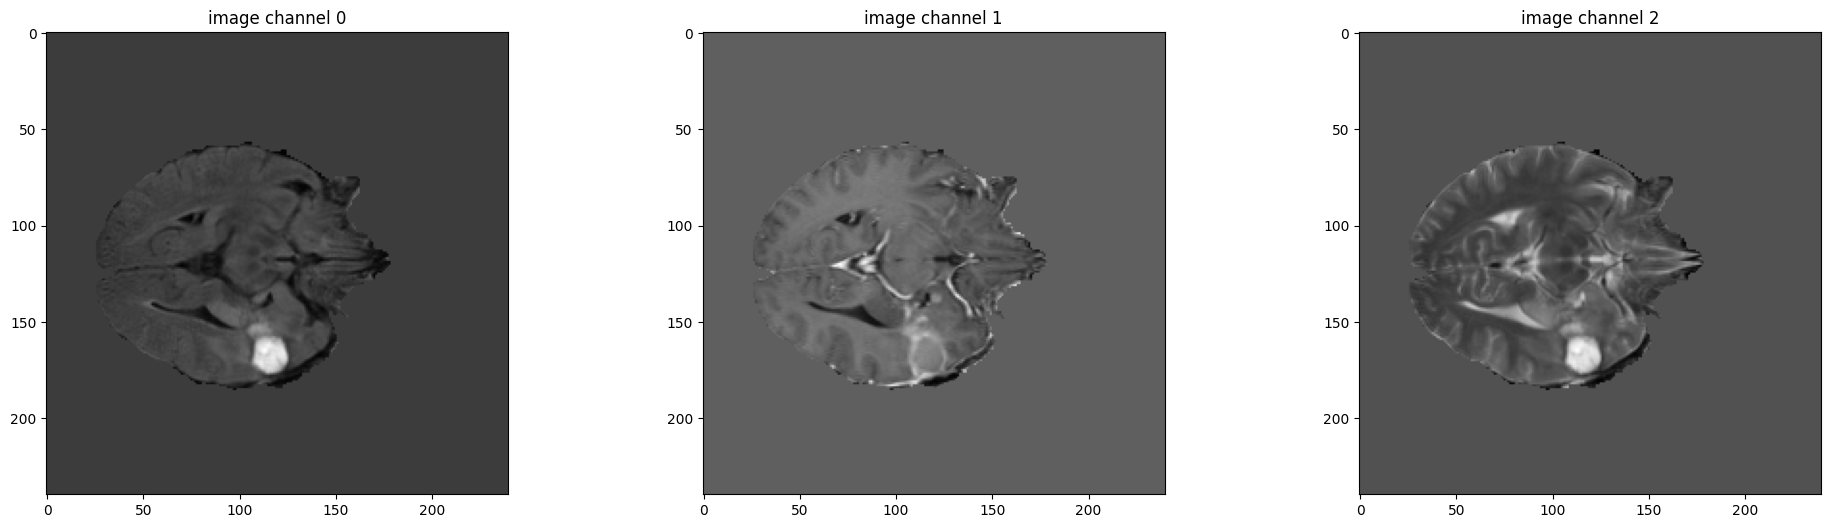

label shape: torch.Size([4, 240, 240, 144])


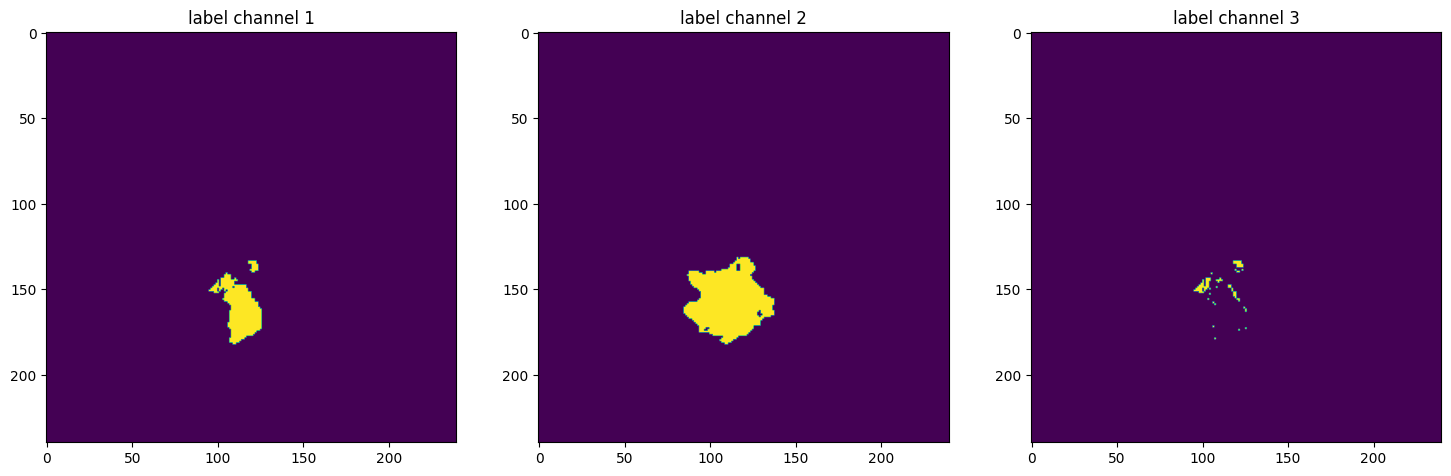

In [11]:
# pick one image from DecathlonDataset to visualize and check the 3 channels
val_data_example = val_ds[70]
print(f"image shape: {val_data_example['image'].shape}")
plt.figure("image", (24, 6))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.title(f"image channel {i}")
    plt.imshow(val_data_example["image"][i, :, :, 60].detach().cpu(), cmap="gray")
plt.show()
# also visualize the 3 channels label corresponding to this image
print(f"label shape: {val_data_example['label'].shape}")
plt.figure("label", (18, 6))
for i in range(1, 4):
    plt.subplot(1, 3, i)
    plt.title(f"label channel {i}")
    plt.imshow(val_data_example["label"][i, :, :, 60].detach().cpu(), vmin=0, vmax=1)
plt.show()

## Define 2D network and losses

In [ ]:
from transformers import Dinov2Model, Dinov2PreTrainedModel
from transformers.modeling_outputs import SemanticSegmenterOutput

class LinearClassifier(torch.nn.Module):
    def __init__(self, in_channels, num_labels=4):
        super(LinearClassifier, self).__init__()
        self.in_channels = in_channels
        self.classifier = torch.nn.Conv2d(in_channels, num_labels, kernel_size=1)

    def forward(self, embeddings):
        # The embeddings shape is [batch_size, num_patches + 1, hidden_size]
        # We need to remove the CLS token and reshape for the conv layer
        patch_embeddings = embeddings[:, 1:, :]  # Remove CLS token

        # Get batch size from input
        batch_size = embeddings.shape[0]

        # Assuming the patches form a 2D grid (e.g., 32x32 for Dinov2-base)
        # Calculate the grid size from the number of patches
        num_patches = patch_embeddings.shape[1]
        grid_size = int(num_patches ** 0.5)  # Assuming square grid

        # Reshape to [batch_size, grid_size, grid_size, hidden_size]
        patch_embeddings = patch_embeddings.reshape(batch_size, grid_size, grid_size, self.in_channels)

        # Permute to [batch_size, hidden_size, grid_size, grid_size] for Conv2d
        patch_embeddings = patch_embeddings.permute(0, 3, 1, 2)

        return self.classifier(patch_embeddings)


class Dinov2ForSemanticSegmentation(Dinov2PreTrainedModel):
    def __init__(self, config):
        super().__init__(config)
        self.dinov2 = Dinov2Model(config)
        self.classifier = LinearClassifier(config.hidden_size, config.num_labels)

    def forward(self, pixel_values, output_hidden_states=False, output_attentions=False, labels=None):
        # Get embeddings from frozen features
        outputs = self.dinov2(pixel_values,
                            output_hidden_states=output_hidden_states,
                            output_attentions=output_attentions)

        # Get the patch embeddings (excluding CLS token)
        patch_embeddings = outputs.last_hidden_state[:, 1:, :]

        # Convert to logits and upsample to the size of the pixel values
        logits = self.classifier(outputs.last_hidden_state)

        # Upsample to match input spatial dimensions
        logits = torch.nn.functional.interpolate(logits, size=pixel_values.shape[2:], mode="bilinear", align_corners=False)

        loss = None
        if labels is not None:
            loss_fct = monai.losses.DiceLoss(softmax=True, to_onehot_y=False)
            loss = loss_fct(logits, labels)

        return SemanticSegmenterOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )

In [16]:
label_dict = {0: "Background", 1: "TC (Tumor core)", 2: "WT (Whole tumor)", 3: "ET (Enhancing tumor)"}  

In [19]:
batch = next(iter(train_loader))
print(batch["image"].shape)
print(batch["label"].shape)

torch.Size([8, 3, 240, 240])
torch.Size([8, 4, 240, 240])


## The training loop

In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Dinov2ForSemanticSegmentation.from_pretrained("facebook/dinov2-base", id2label=label_dict, num_labels=len(label_dict)).to(device)
for name, param in model.named_parameters():
  if name.startswith("dinov2"):
    param.requires_grad = False
optimizer = torch.optim.Adam(model.parameters(), 2e-4) 

config.json:   0%|          | 0.00/548 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of Dinov2ForSemanticSegmentation were not initialized from the model checkpoint at facebook/dinov2-base and are newly initialized: ['classifier.classifier.bias', 'classifier.classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [21]:
model

Dinov2ForSemanticSegmentation(
  (dinov2): Dinov2Model(
    (embeddings): Dinov2Embeddings(
      (patch_embeddings): Dinov2PatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(14, 14), stride=(14, 14))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): Dinov2Encoder(
      (layer): ModuleList(
        (0-11): 12 x Dinov2Layer(
          (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (attention): Dinov2Attention(
            (attention): Dinov2SelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
            )
            (output): Dinov2SelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (layer_scale1): Dinov2Lay

----------
epoch 1/10
200, train_loss: 0.6423
400, train_loss: 0.7514
600, train_loss: 0.7578
800, train_loss: 0.7351
1000, train_loss: 0.7541
1200, train_loss: 0.7569
1400, train_loss: 0.7064
1600, train_loss: 0.5053
1800, train_loss: 0.7538
2000, train_loss: 0.5374
2200, train_loss: 0.7566
2400, train_loss: 0.7445
2600, train_loss: 0.7604
2800, train_loss: 0.7509
3000, train_loss: 0.6343
3200, train_loss: 0.7513
3400, train_loss: 0.6347
3600, train_loss: 0.7506
3800, train_loss: 0.4805
4000, train_loss: 0.7501
4200, train_loss: 0.6272
4400, train_loss: 0.6000
4600, train_loss: 0.7510
4800, train_loss: 0.5636
5000, train_loss: 0.7506
5200, train_loss: 0.7352
5400, train_loss: 0.7526
5600, train_loss: 0.5038
5800, train_loss: 0.7705
6000, train_loss: 0.4062
6200, train_loss: 0.7500
6400, train_loss: 0.7241
6600, train_loss: 0.7134
6800, train_loss: 0.7498
epoch 1 average loss: 0.6772
New best loss: 0.8277
Dice per channel: tensor([[0.1050, 0.0630, 0.0140]], device='cuda:0')
Current dic

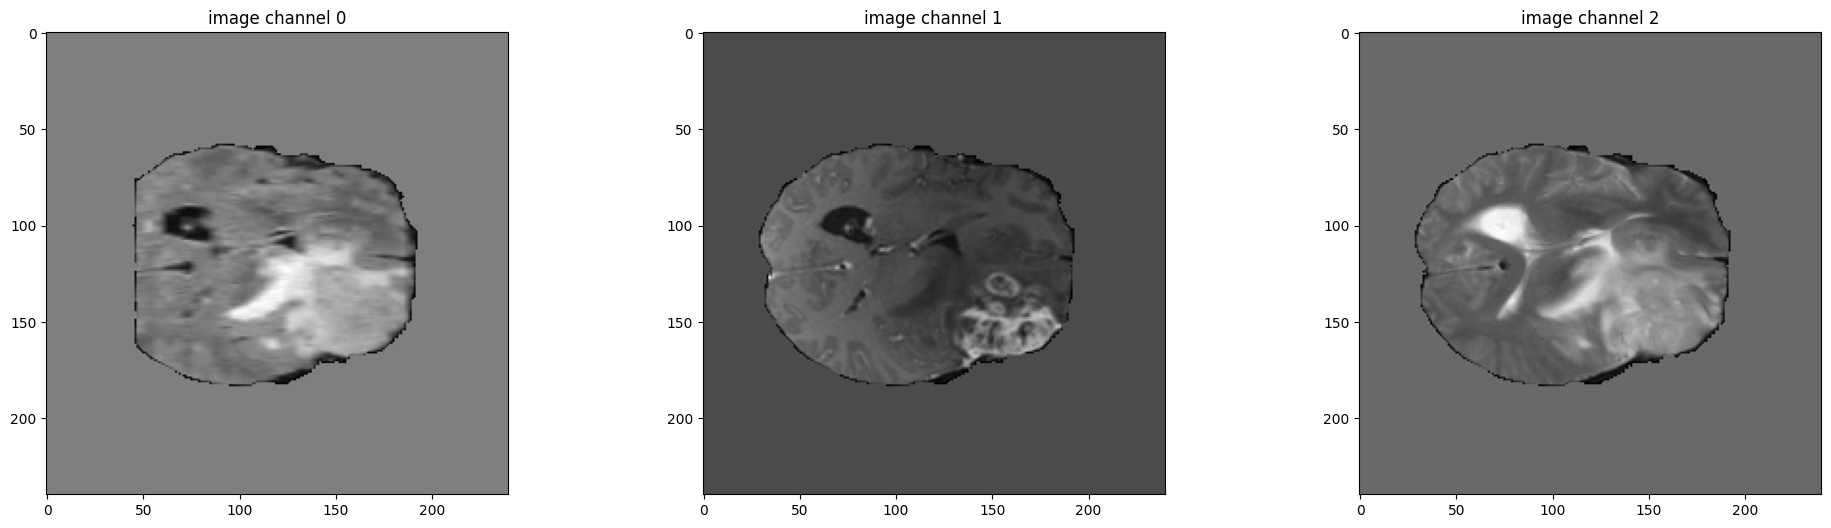

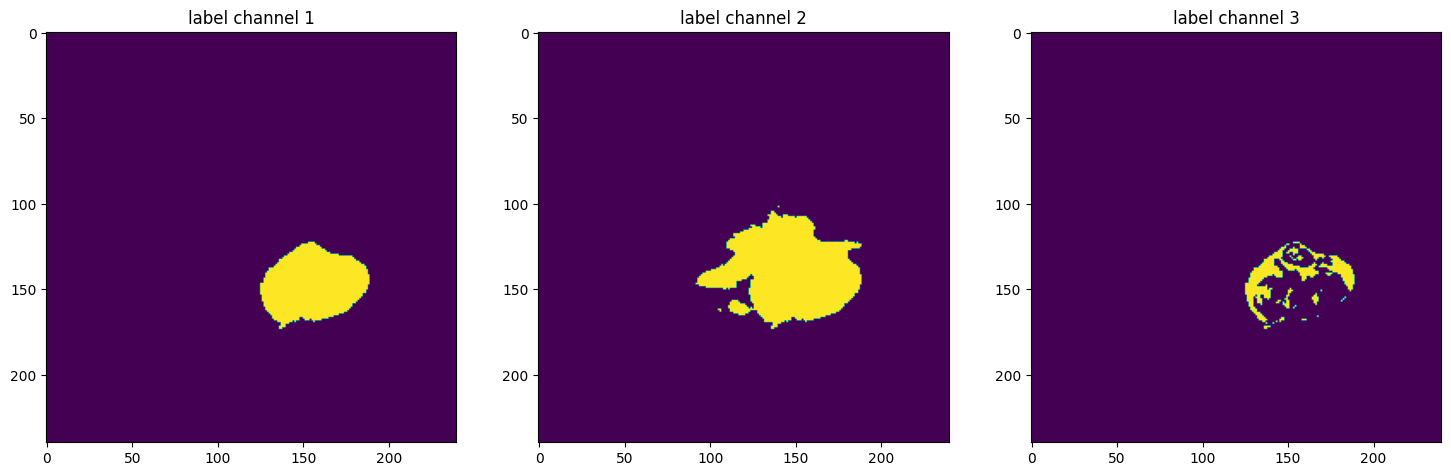

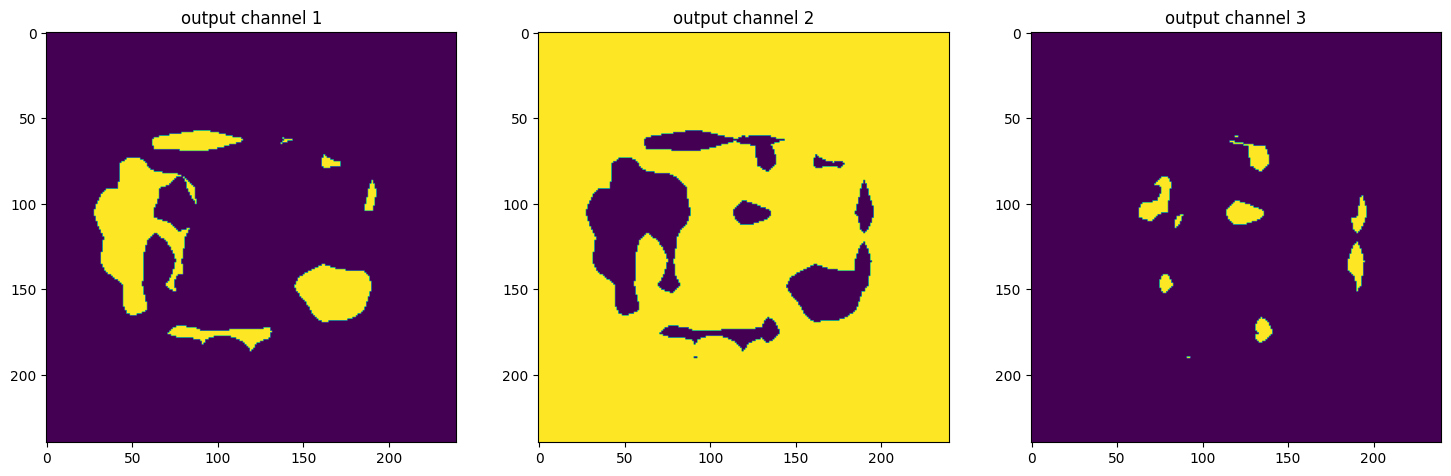

----------
epoch 2/10
200, train_loss: 0.4838
400, train_loss: 0.7501
600, train_loss: 0.7529
800, train_loss: 0.6791
1000, train_loss: 0.7549
1200, train_loss: 0.7579
1400, train_loss: 0.7083
1600, train_loss: 0.4187
1800, train_loss: 0.7520
2000, train_loss: 0.4947
2200, train_loss: 0.7564
2400, train_loss: 0.7391
2600, train_loss: 0.5832
2800, train_loss: 0.5001
3000, train_loss: 0.6288
3200, train_loss: 0.5021
3400, train_loss: 0.4622
3600, train_loss: 0.5004
3800, train_loss: 0.5256
4000, train_loss: 0.5000
4200, train_loss: 0.4798
4400, train_loss: 0.3335
4600, train_loss: 0.5004
4800, train_loss: 0.5083
5000, train_loss: 0.5002
5200, train_loss: 0.6709
5400, train_loss: 0.5028
5600, train_loss: 0.4659
5800, train_loss: 0.5614
6000, train_loss: 0.4785
6200, train_loss: 0.5000
6400, train_loss: 0.7206
6600, train_loss: 0.4918
6800, train_loss: 0.4997
epoch 2 average loss: 0.5686
Dice per channel: tensor([[0.1078, 0.0638, 0.0000]], device='cuda:0')
Current dice: 0.05894619226455688

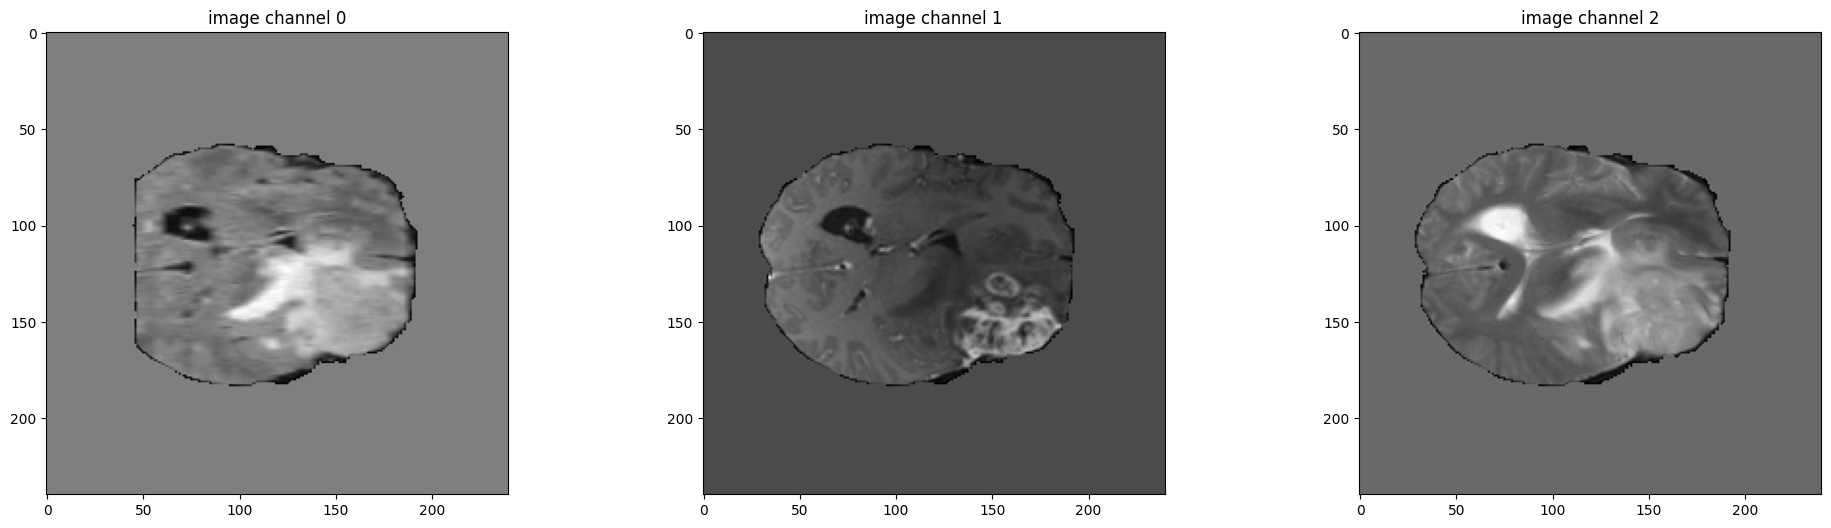

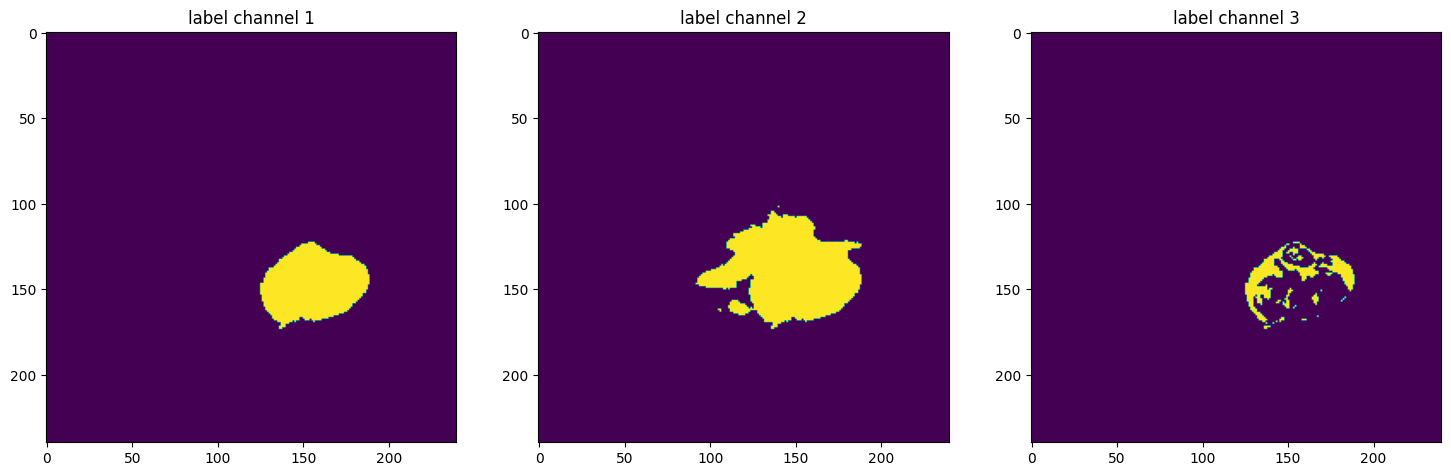

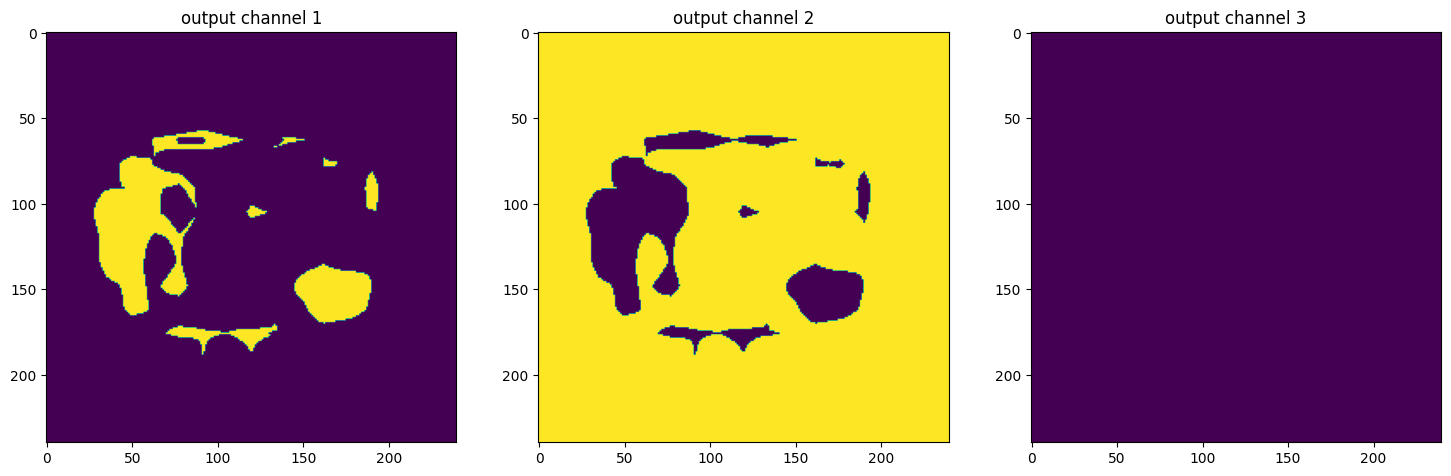

----------
epoch 3/10
200, train_loss: 0.4517
400, train_loss: 0.6563
600, train_loss: 0.5024
800, train_loss: 0.4188
1000, train_loss: 0.5052
1200, train_loss: 0.5063
1400, train_loss: 0.5914
1600, train_loss: 0.5006
1800, train_loss: 0.5020
2000, train_loss: 0.4895
2200, train_loss: 0.5055
2400, train_loss: 0.4883
2600, train_loss: 0.5054
2800, train_loss: 0.5001
3000, train_loss: 0.6105
3200, train_loss: 0.5019
3400, train_loss: 0.4607
3600, train_loss: 0.5002
3800, train_loss: 0.5227
4000, train_loss: 0.4999
4200, train_loss: 0.4738
4400, train_loss: 0.3288
4600, train_loss: 0.5003
4800, train_loss: 0.5059
5000, train_loss: 0.5001
5200, train_loss: 0.6704
5400, train_loss: 0.5031
5600, train_loss: 0.4541
5800, train_loss: 0.5314
6000, train_loss: 0.4695
6200, train_loss: 0.4999
6400, train_loss: 0.7113
6600, train_loss: 0.4798
6800, train_loss: 0.4988
epoch 3 average loss: 0.5051
New best loss: 0.8211
Dice per channel: tensor([[0.1263, 0.0637, 0.0000]], device='cuda:0')
Current dic

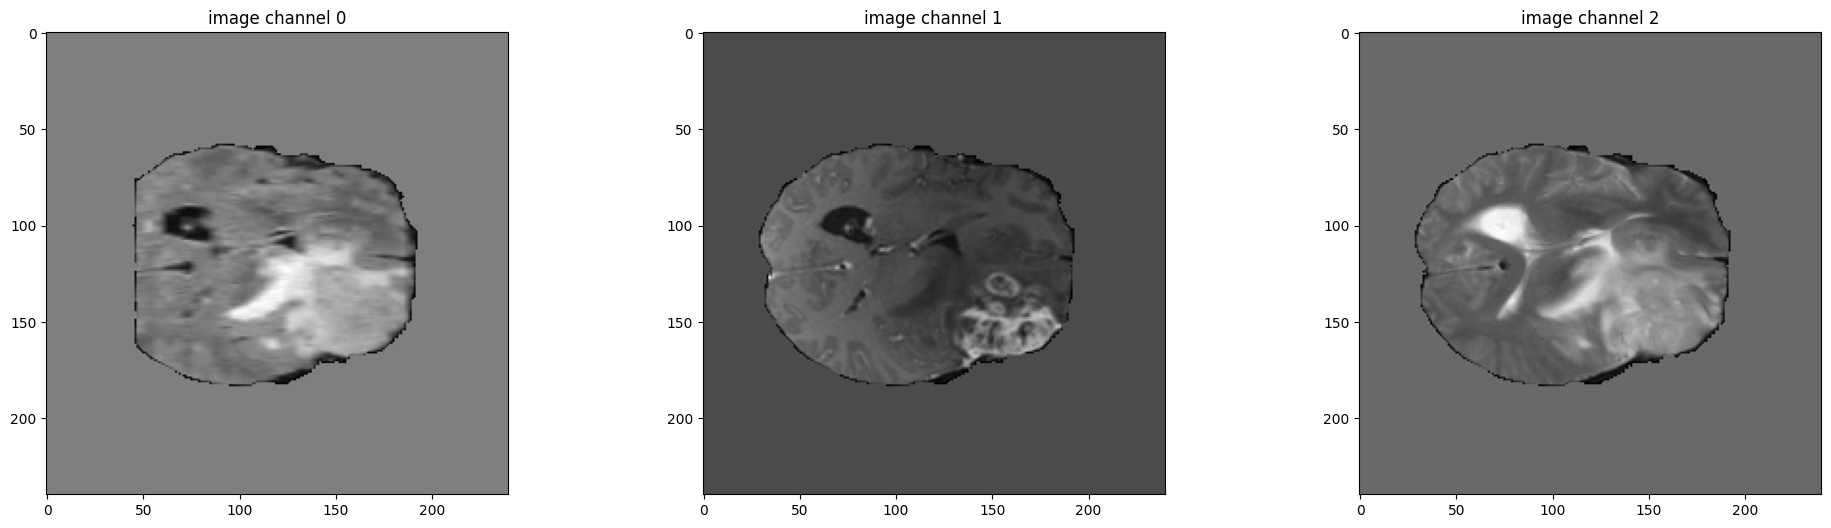

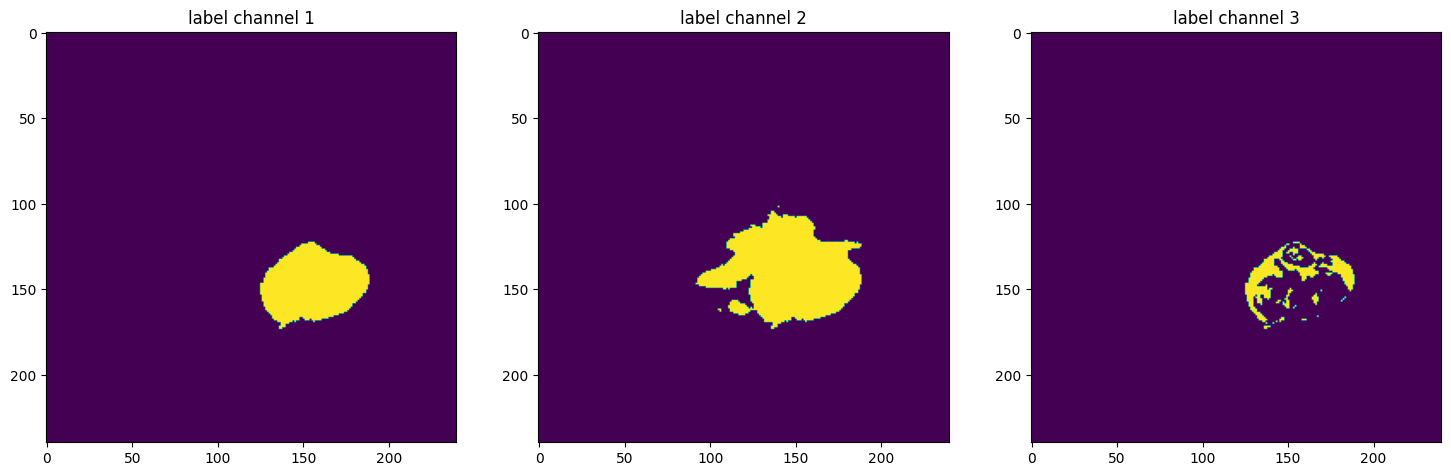

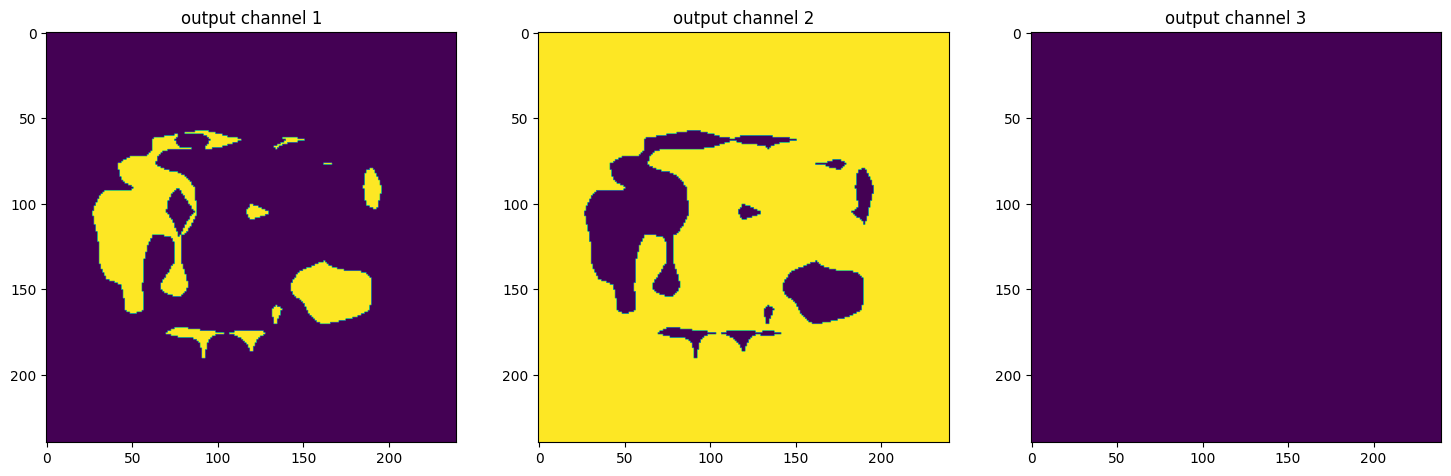

----------
epoch 4/10
200, train_loss: 0.4318
400, train_loss: 0.5000
600, train_loss: 0.5022
800, train_loss: 0.4163
1000, train_loss: 0.5052
1200, train_loss: 0.5057
1400, train_loss: 0.5993
1600, train_loss: 0.4779
1800, train_loss: 0.5027
2000, train_loss: 0.4835
2200, train_loss: 0.5050
2400, train_loss: 0.4877
2600, train_loss: 0.5037
2800, train_loss: 0.5001
3000, train_loss: 0.6033
3200, train_loss: 0.5018
3400, train_loss: 0.4576
3600, train_loss: 0.5001
3800, train_loss: 0.5189
4000, train_loss: 0.4999
4200, train_loss: 0.4704
4400, train_loss: 0.3286
4600, train_loss: 0.5003
4800, train_loss: 0.5004
5000, train_loss: 0.5001
5200, train_loss: 0.6693
5400, train_loss: 0.5030
5600, train_loss: 0.4452
5800, train_loss: 0.5316
6000, train_loss: 0.4634
6200, train_loss: 0.4999
6400, train_loss: 0.7049
6600, train_loss: 0.4738
6800, train_loss: 0.4968
epoch 4 average loss: 0.4917
New best loss: 0.8174
Dice per channel: tensor([[0.1280, 0.0639, 0.0000]], device='cuda:0')
Current dic

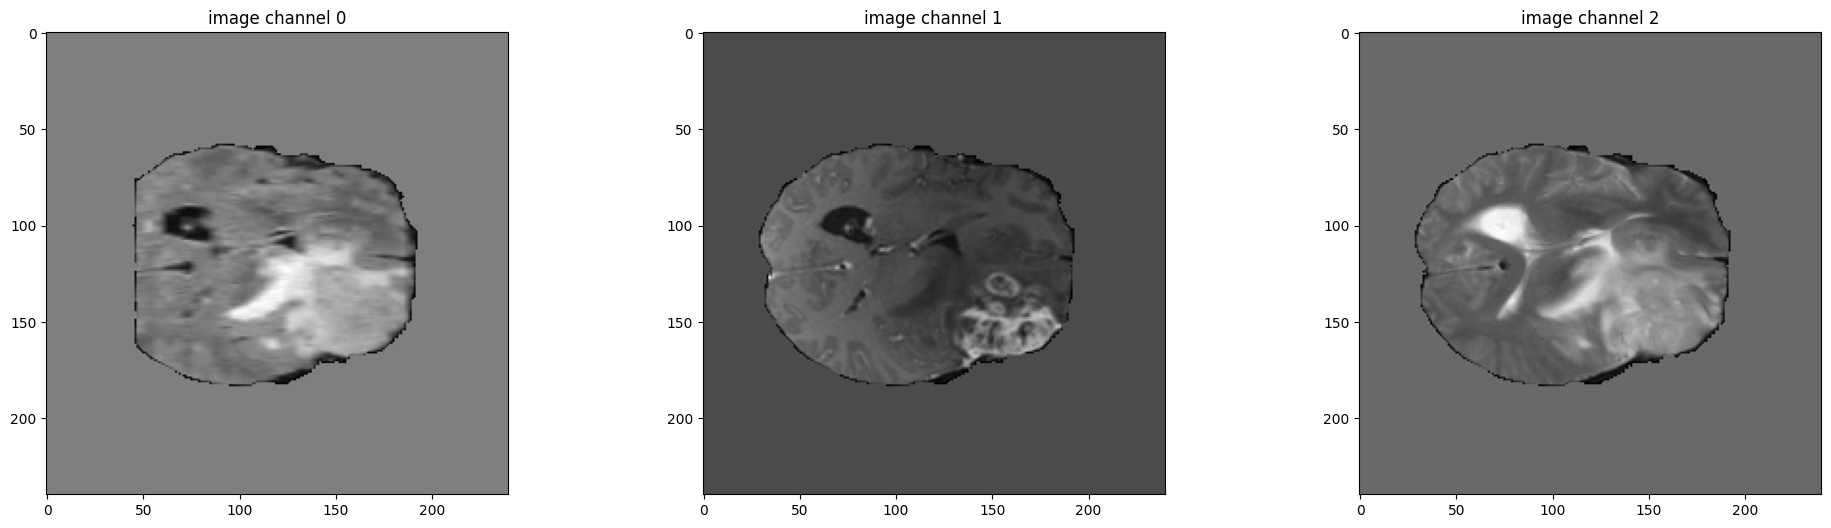

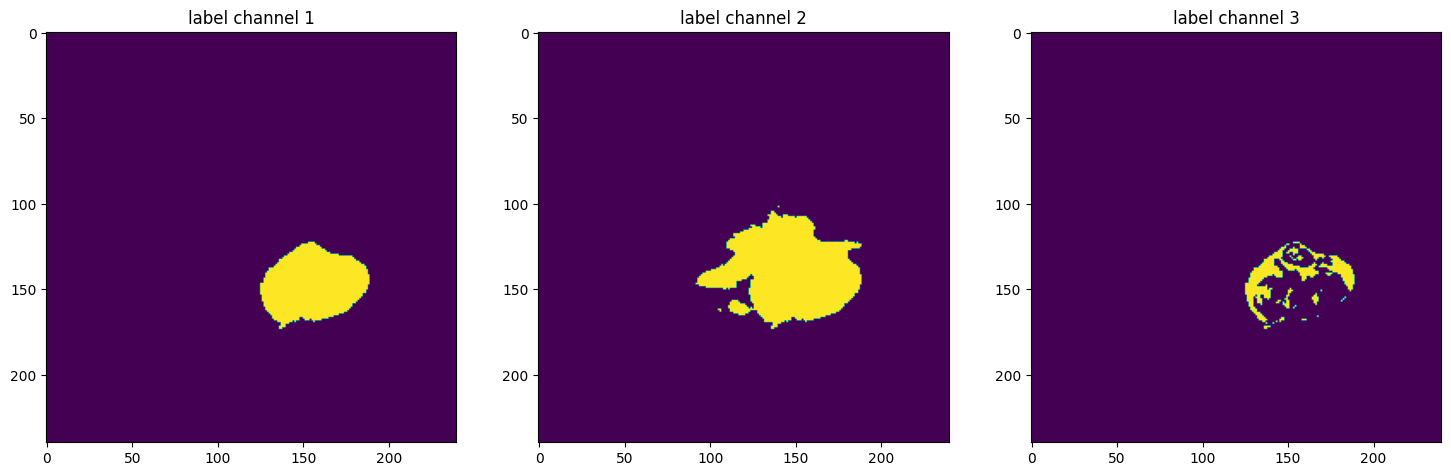

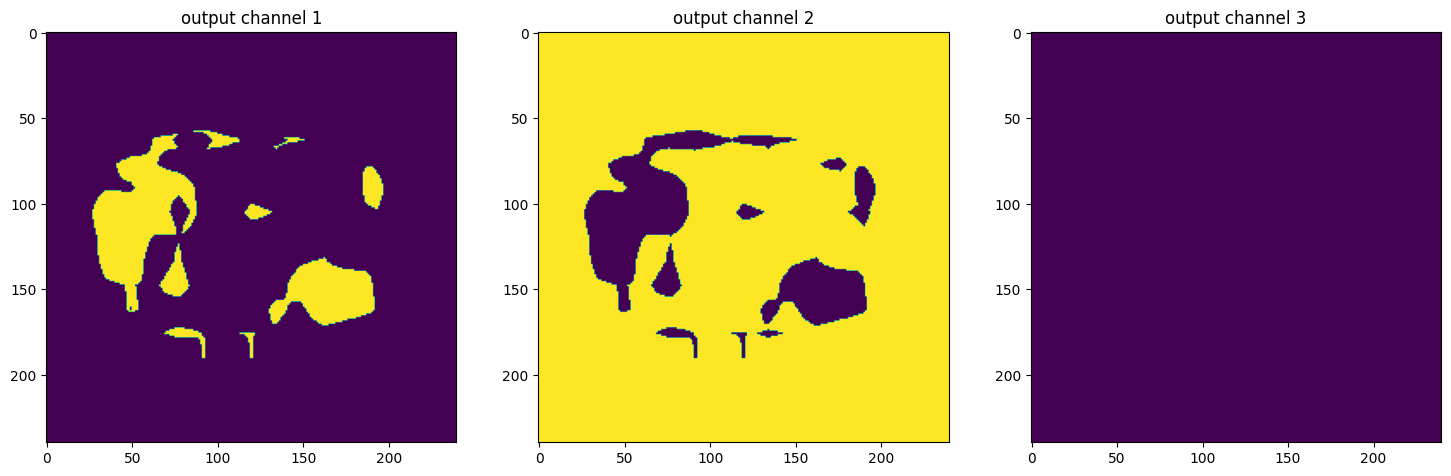

----------
epoch 5/10
200, train_loss: 0.4227
400, train_loss: 0.5000
600, train_loss: 0.5021
800, train_loss: 0.4150
1000, train_loss: 0.5051
1200, train_loss: 0.5052
1400, train_loss: 0.6059
1600, train_loss: 0.4595
1800, train_loss: 0.5031
2000, train_loss: 0.4797
2200, train_loss: 0.5046
2400, train_loss: 0.4874
2600, train_loss: 0.5033
2800, train_loss: 0.5001
3000, train_loss: 0.5974
3200, train_loss: 0.5017
3400, train_loss: 0.4551
3600, train_loss: 0.5001
3800, train_loss: 0.5165
4000, train_loss: 0.4999
4200, train_loss: 0.4690
4400, train_loss: 0.3285
4600, train_loss: 0.5002
4800, train_loss: 0.4914
5000, train_loss: 0.5000
5200, train_loss: 0.6679
5400, train_loss: 0.5031
5600, train_loss: 0.4389
5800, train_loss: 0.5315
6000, train_loss: 0.4582
6200, train_loss: 0.4999
6400, train_loss: 0.7005
6600, train_loss: 0.4700
6800, train_loss: 0.4945
epoch 5 average loss: 0.4901
New best loss: 0.8157
Dice per channel: tensor([[0.1219, 0.0646, 0.0000]], device='cuda:0')
Current dic

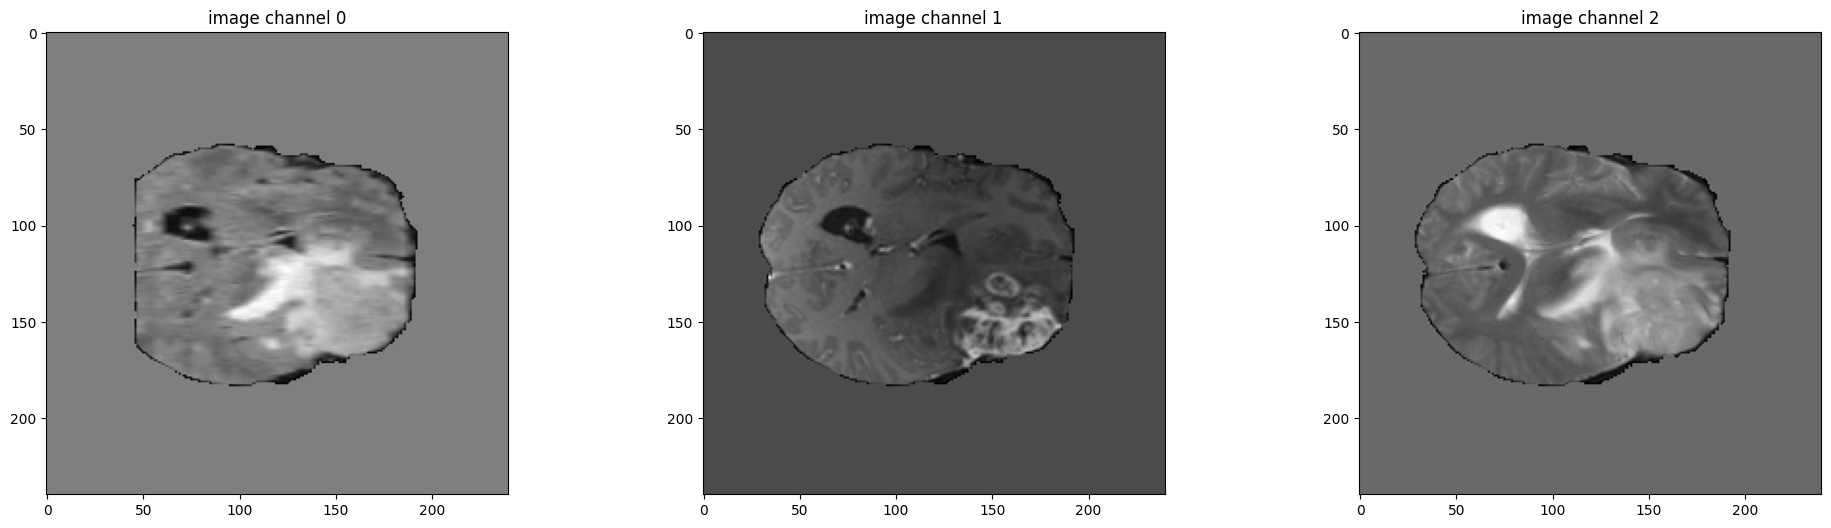

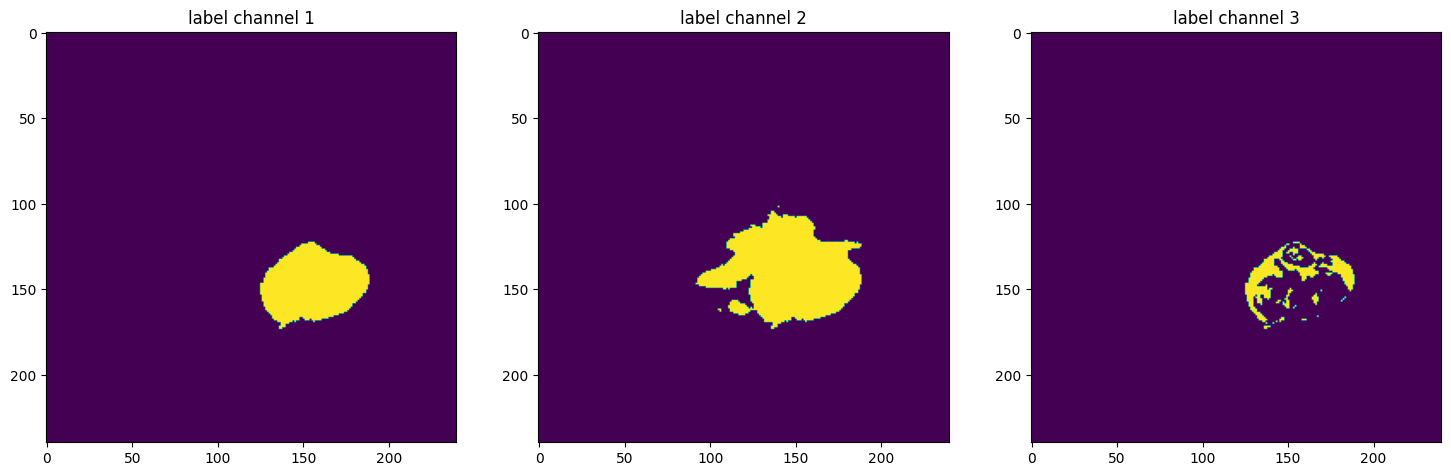

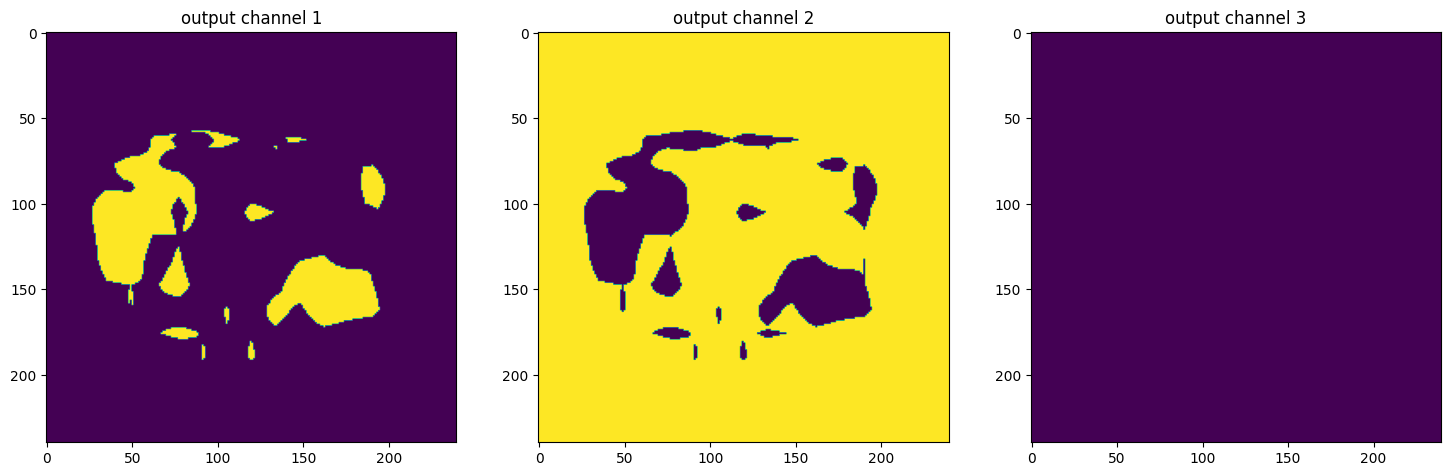

----------
epoch 6/10
200, train_loss: 0.4161
400, train_loss: 0.5000
600, train_loss: 0.5021
800, train_loss: 0.4144
1000, train_loss: 0.5050
1200, train_loss: 0.5049
1400, train_loss: 0.6100
1600, train_loss: 0.4475
1800, train_loss: 0.5032
2000, train_loss: 0.4765
2200, train_loss: 0.5044
2400, train_loss: 0.4872
2600, train_loss: 0.5031
2800, train_loss: 0.5000
3000, train_loss: 0.5906
3200, train_loss: 0.5015
3400, train_loss: 0.4521
3600, train_loss: 0.5001
3800, train_loss: 0.5146
4000, train_loss: 0.4999
4200, train_loss: 0.4683
4400, train_loss: 0.3284
4600, train_loss: 0.5002
4800, train_loss: 0.4827
5000, train_loss: 0.5000
5200, train_loss: 0.6668
5400, train_loss: 0.5032
5600, train_loss: 0.4349
5800, train_loss: 0.5314
6000, train_loss: 0.4520
6200, train_loss: 0.4999
6400, train_loss: 0.6977
6600, train_loss: 0.4685
6800, train_loss: 0.4924
epoch 6 average loss: 0.4874
Dice per channel: tensor([[0.1197, 0.0655, 0.0000]], device='cuda:0')
Current dice: 0.06150916218757629

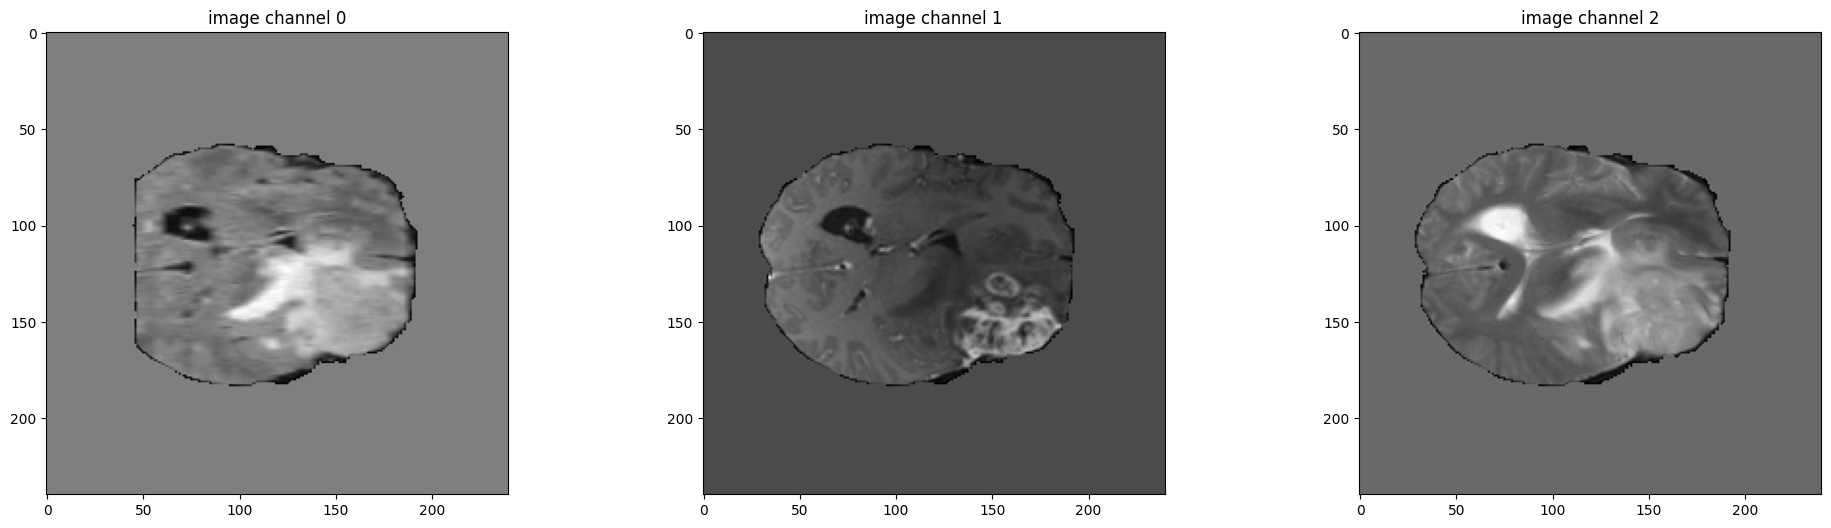

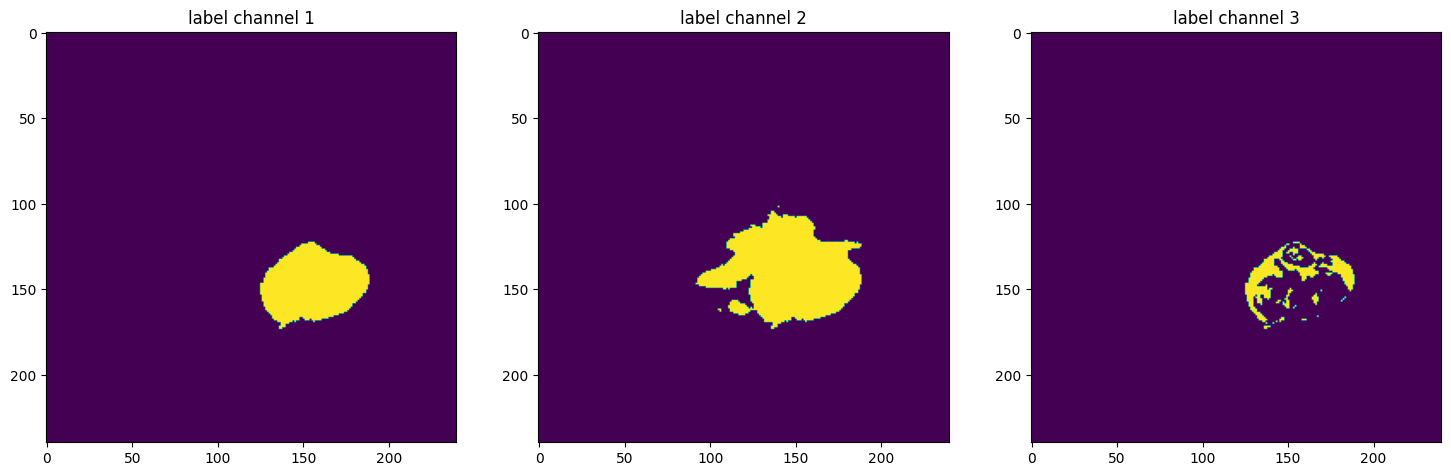

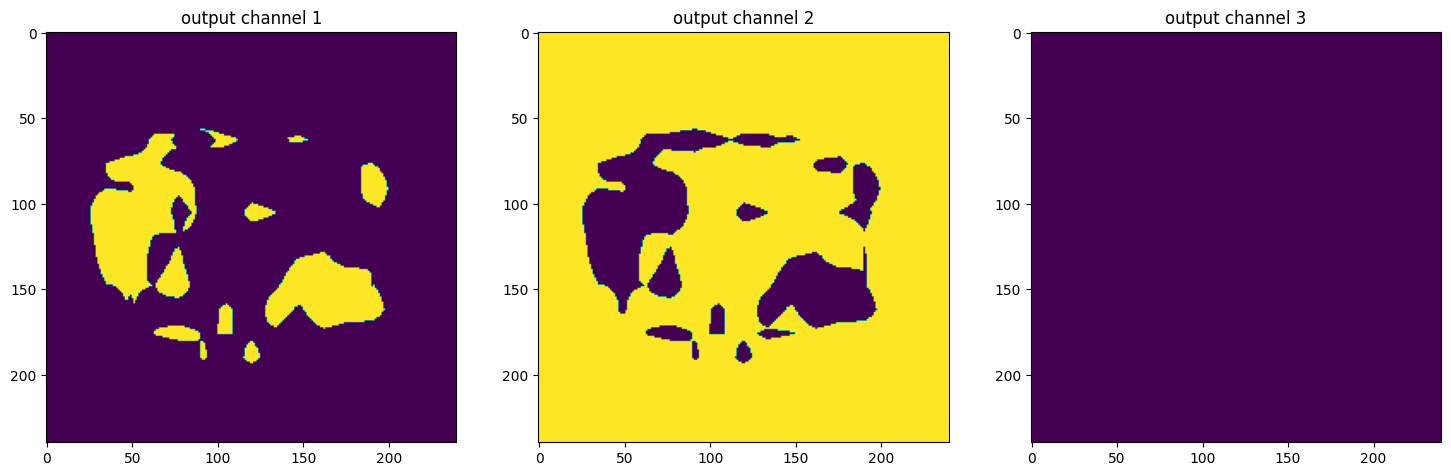

----------
epoch 7/10
200, train_loss: 0.4120
400, train_loss: 0.1879
600, train_loss: 0.5019
800, train_loss: 0.4153
1000, train_loss: 0.5051
1200, train_loss: 0.5042
1400, train_loss: 0.6145
1600, train_loss: 0.4372
1800, train_loss: 0.5038
2000, train_loss: 0.4719
2200, train_loss: 0.5042
2400, train_loss: 0.4876
2600, train_loss: 0.5029
2800, train_loss: 0.5000
3000, train_loss: 0.5810
3200, train_loss: 0.5014
3400, train_loss: 0.4467
3600, train_loss: 0.5001
3800, train_loss: 0.5132
4000, train_loss: 0.4999
4200, train_loss: 0.4674
4400, train_loss: 0.3290
4600, train_loss: 0.5002
4800, train_loss: 0.4760
5000, train_loss: 0.5000
5200, train_loss: 0.6661
5400, train_loss: 0.5031
5600, train_loss: 0.4330
5800, train_loss: 0.4689
6000, train_loss: 0.4446
6200, train_loss: 0.4999
6400, train_loss: 0.6997
6600, train_loss: 0.4639
6800, train_loss: 0.4911
epoch 7 average loss: 0.4532
Dice per channel: tensor([[0.1182, 0.0656, 0.0000]], device='cuda:0')
Current dice: 0.06147557497024536

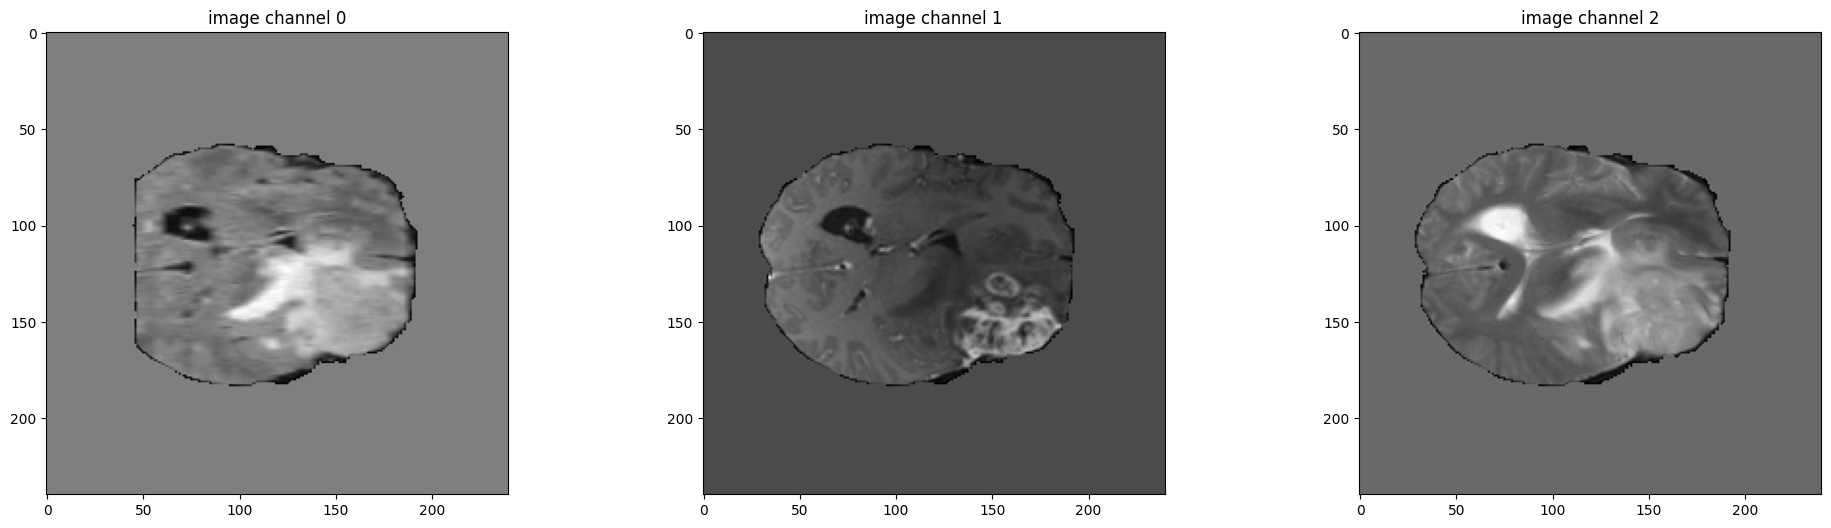

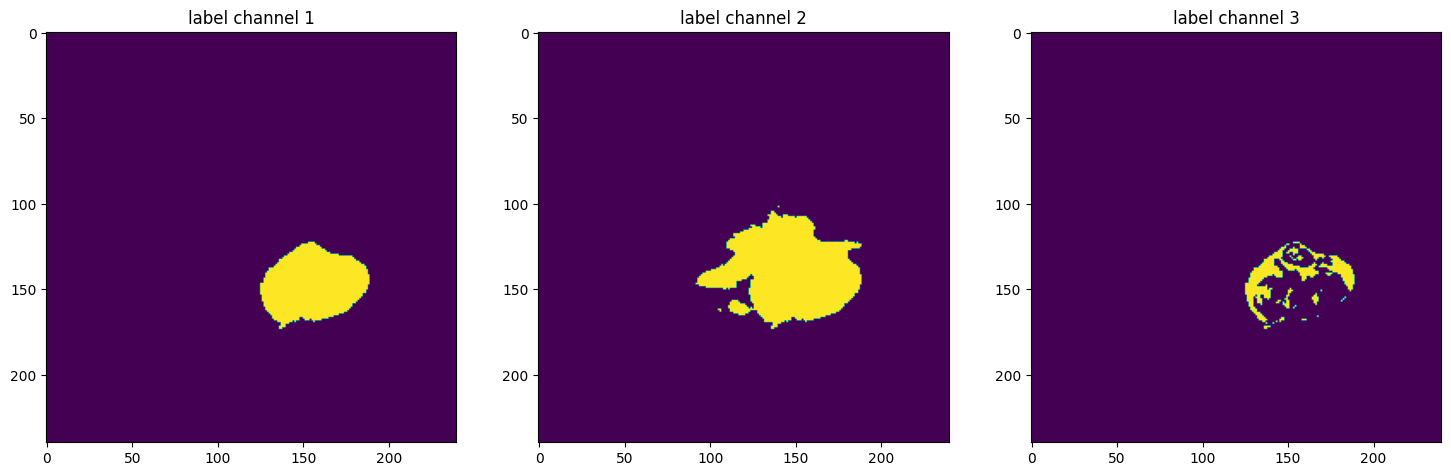

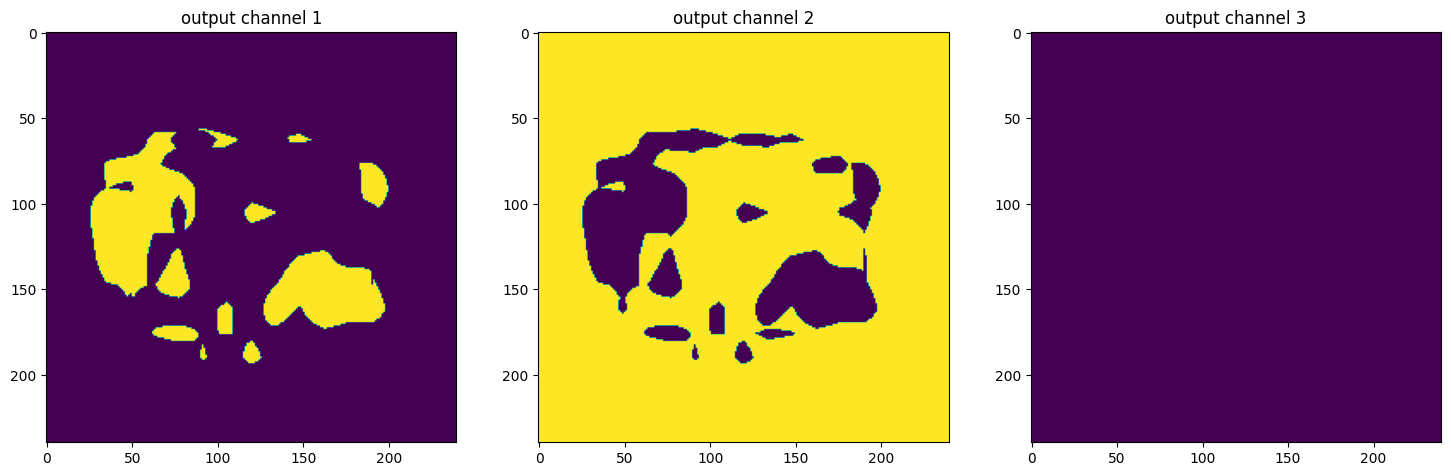

----------
epoch 8/10
200, train_loss: 0.4090
400, train_loss: 0.1875
600, train_loss: 0.5019
800, train_loss: 0.4133
1000, train_loss: 0.5050
1200, train_loss: 0.5043
1400, train_loss: 0.6174
1600, train_loss: 0.4353
1800, train_loss: 0.5029
2000, train_loss: 0.4702
2200, train_loss: 0.5040
2400, train_loss: 0.4874
2600, train_loss: 0.5026
2800, train_loss: 0.5000
3000, train_loss: 0.5751
3200, train_loss: 0.5013
3400, train_loss: 0.4445
3600, train_loss: 0.5001
3800, train_loss: 0.5120
4000, train_loss: 0.4998
4200, train_loss: 0.4667
4400, train_loss: 0.3284
4600, train_loss: 0.5002
4800, train_loss: 0.4720
5000, train_loss: 0.5000
5200, train_loss: 0.6650
5400, train_loss: 0.5024
5600, train_loss: 0.4309
5800, train_loss: 0.4689
6000, train_loss: 0.4355
6200, train_loss: 0.4999
6400, train_loss: 0.6992
6600, train_loss: 0.4648
6800, train_loss: 0.4907
epoch 8 average loss: 0.4524
Dice per channel: tensor([[0.0728, 0.0736, 0.0000]], device='cuda:0')
Current dice: 0.05989112704992294

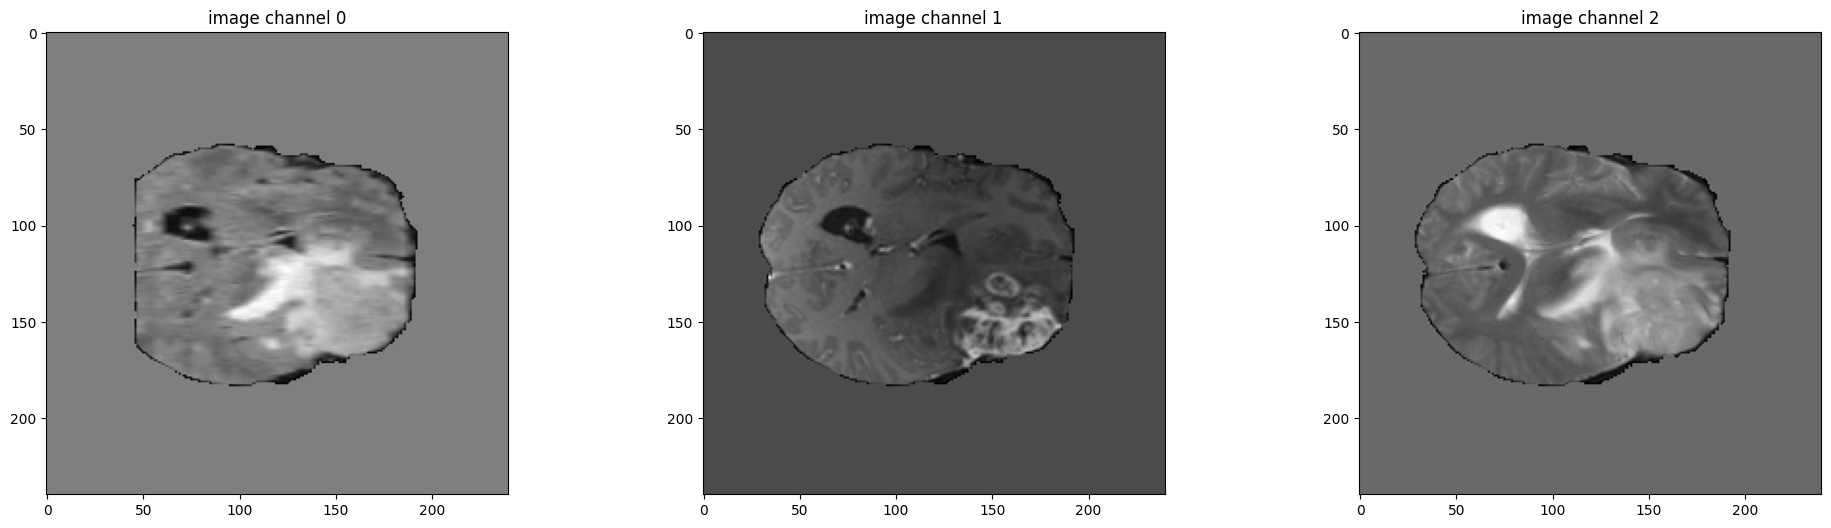

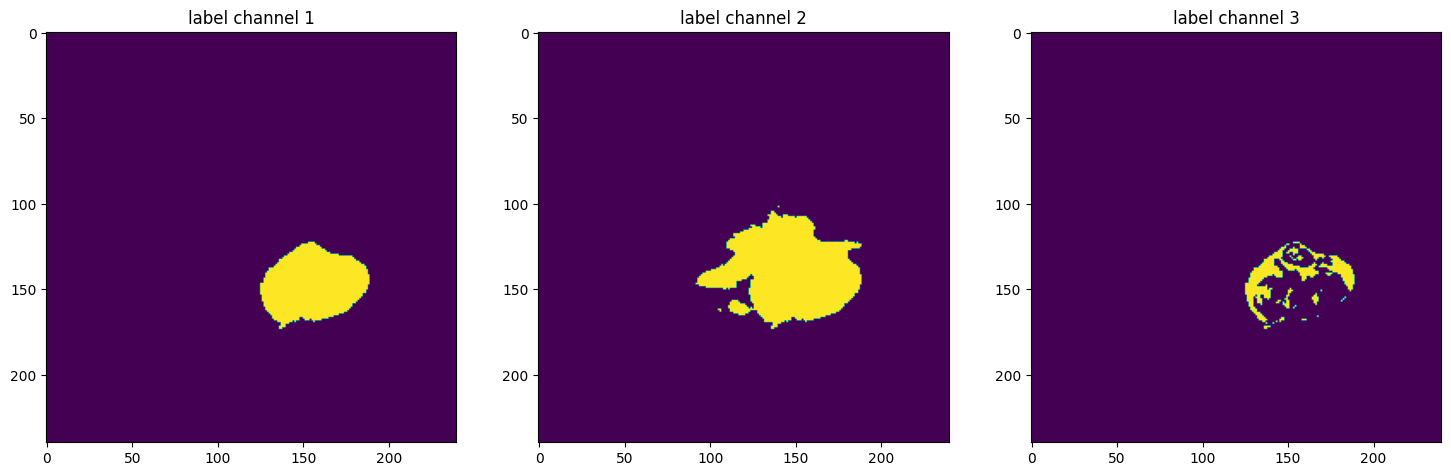

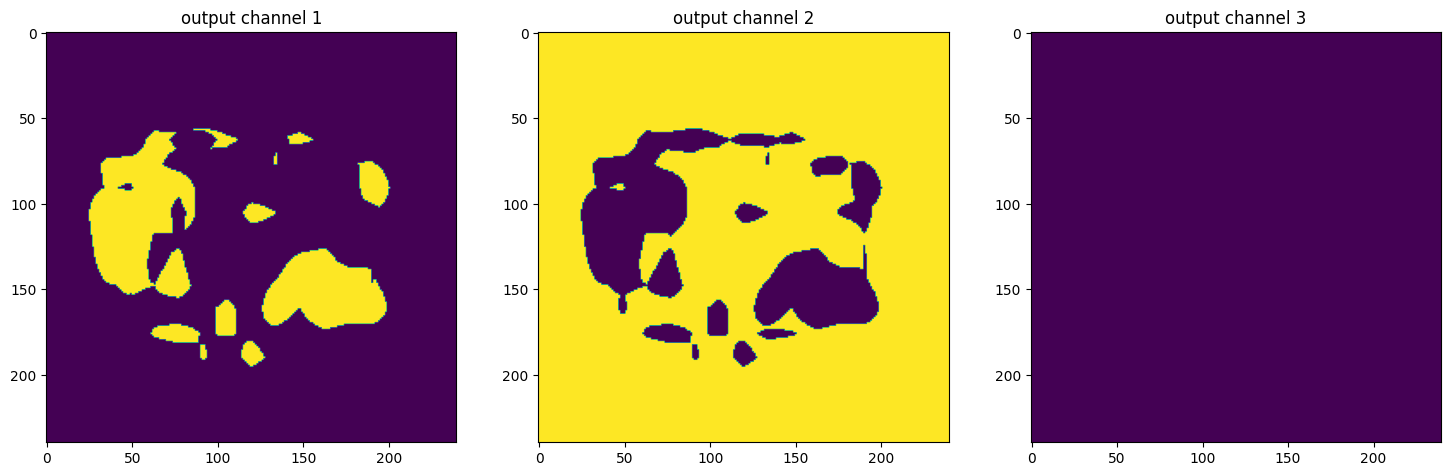

----------
epoch 9/10
200, train_loss: 0.4070
400, train_loss: 0.1875
600, train_loss: 0.5019
800, train_loss: 0.4125
1000, train_loss: 0.5050
1200, train_loss: 0.5043
1400, train_loss: 0.6186
1600, train_loss: 0.4359
1800, train_loss: 0.5023
2000, train_loss: 0.4676
2200, train_loss: 0.5038
2400, train_loss: 0.4873
2600, train_loss: 0.5025
2800, train_loss: 0.5000
3000, train_loss: 0.5667
3200, train_loss: 0.5012
3400, train_loss: 0.4415
3600, train_loss: 0.5000
3800, train_loss: 0.5124
4000, train_loss: 0.4998
4200, train_loss: 0.4667
4400, train_loss: 0.3271
4600, train_loss: 0.5002
4800, train_loss: 0.4696
5000, train_loss: 0.5000
5200, train_loss: 0.6634
5400, train_loss: 0.5006
5600, train_loss: 0.4292
5800, train_loss: 0.4687
6000, train_loss: 0.4316
6200, train_loss: 0.4997
6400, train_loss: 0.7164
6600, train_loss: 0.3120
6800, train_loss: 0.2456
epoch 9 average loss: 0.4440
Dice per channel: tensor([[0.0000, 0.0739, 0.0000]], device='cuda:0')
Current dice: 0.05597249791026115

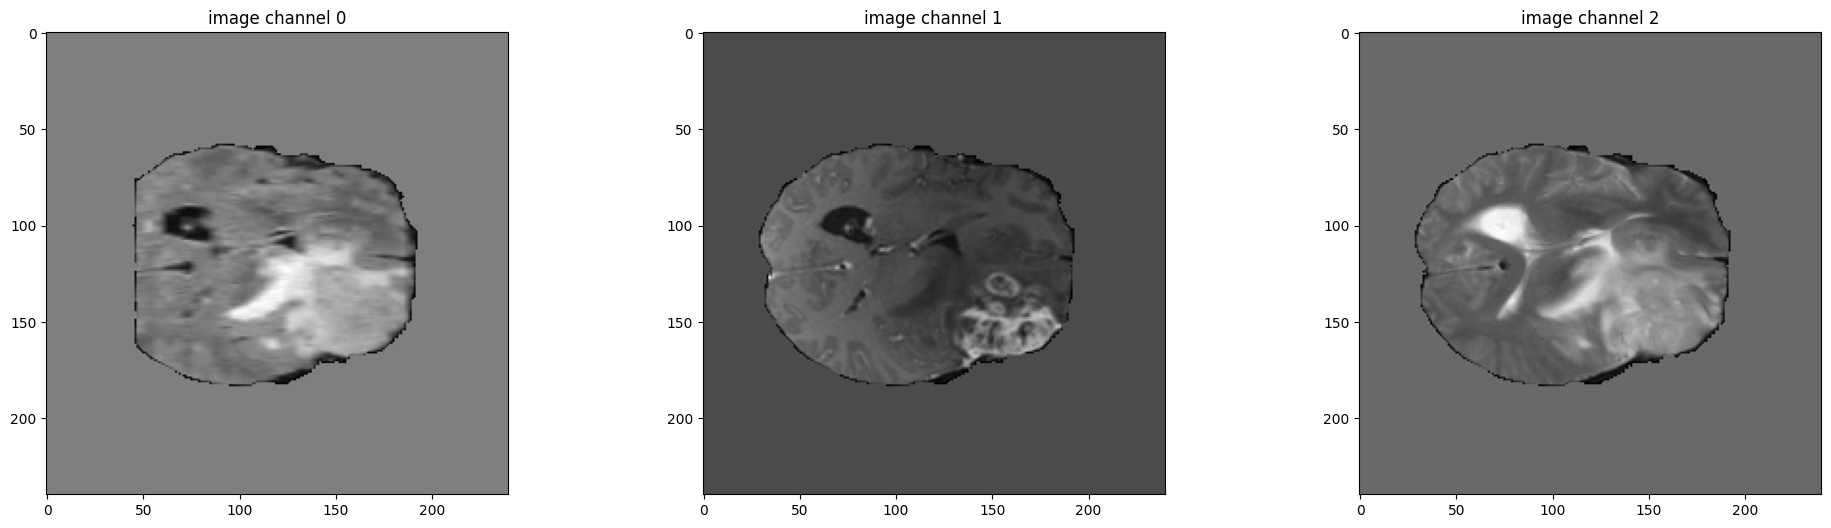

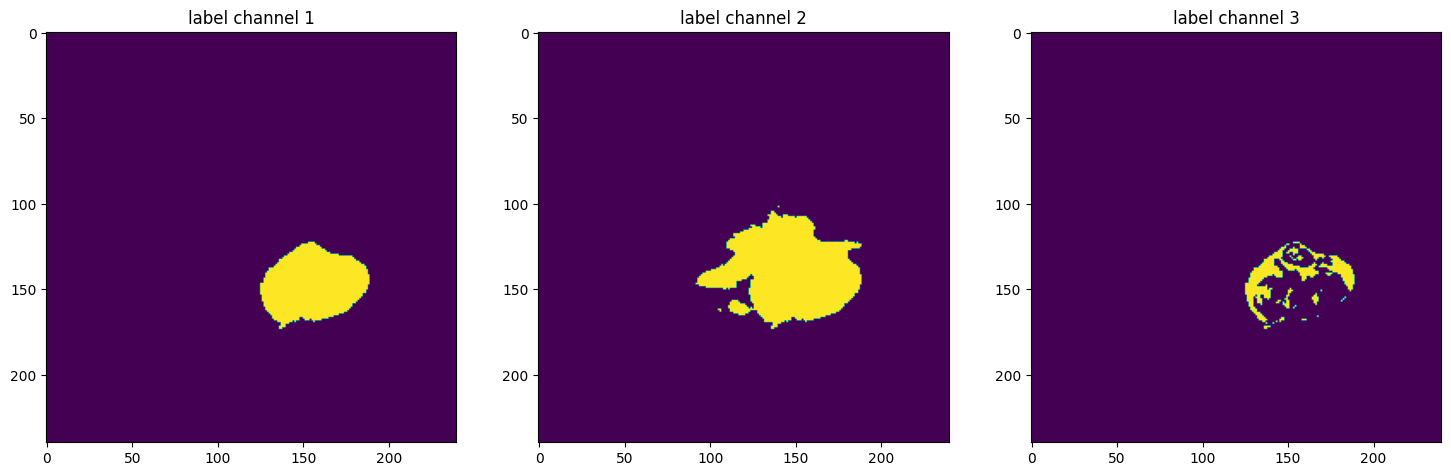

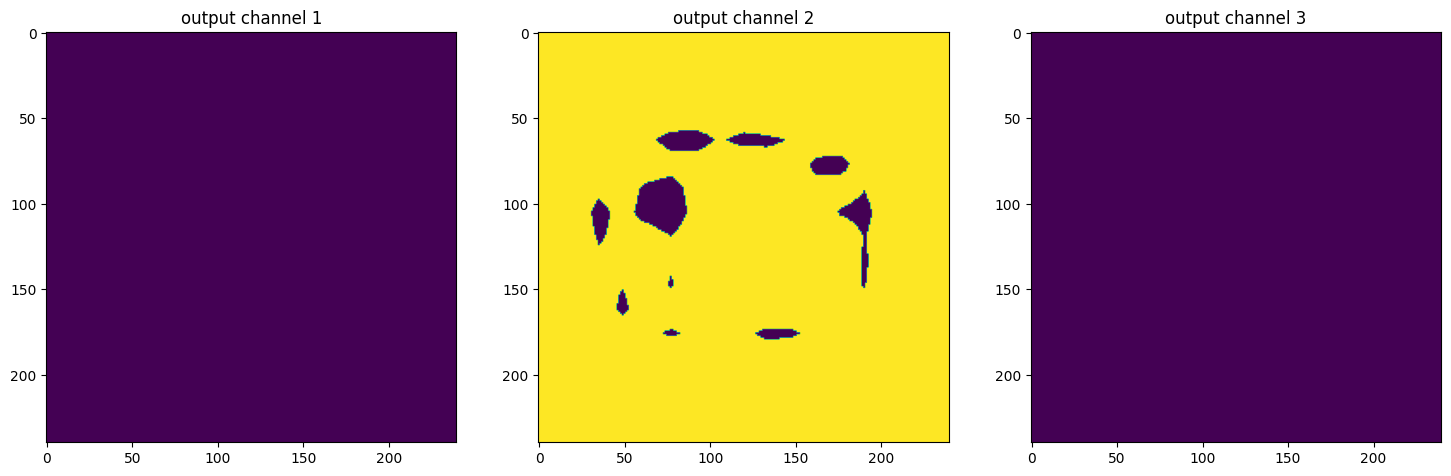

----------
epoch 10/10
200, train_loss: 0.5387
400, train_loss: 0.0937
600, train_loss: 0.2516
800, train_loss: 0.1615
1000, train_loss: 0.2544
1200, train_loss: 0.2551
1400, train_loss: 0.4958
1600, train_loss: 0.5298
1800, train_loss: 0.2504
2000, train_loss: 0.5335
2200, train_loss: 0.2538
2400, train_loss: 0.2395
2600, train_loss: 0.2528
2800, train_loss: 0.2500
3000, train_loss: 0.6109
3200, train_loss: 0.2506
3400, train_loss: 0.2900
3600, train_loss: 0.2500
3800, train_loss: 0.5512
4000, train_loss: 0.2499
4200, train_loss: 0.4927
4400, train_loss: 0.0844
4600, train_loss: 0.2501
4800, train_loss: 0.4471
5000, train_loss: 0.2500
5200, train_loss: 0.5975
5400, train_loss: 0.2503
5600, train_loss: 0.5586
5800, train_loss: 0.2491
6000, train_loss: 0.5205
6200, train_loss: 0.2499
6400, train_loss: 0.7396
6600, train_loss: 0.2417
6800, train_loss: 0.2401
epoch 10 average loss: 0.3270
Dice per channel: tensor([[0.0000, 0.0779, 0.0000]], device='cuda:0')
Current dice: 0.052970834076404

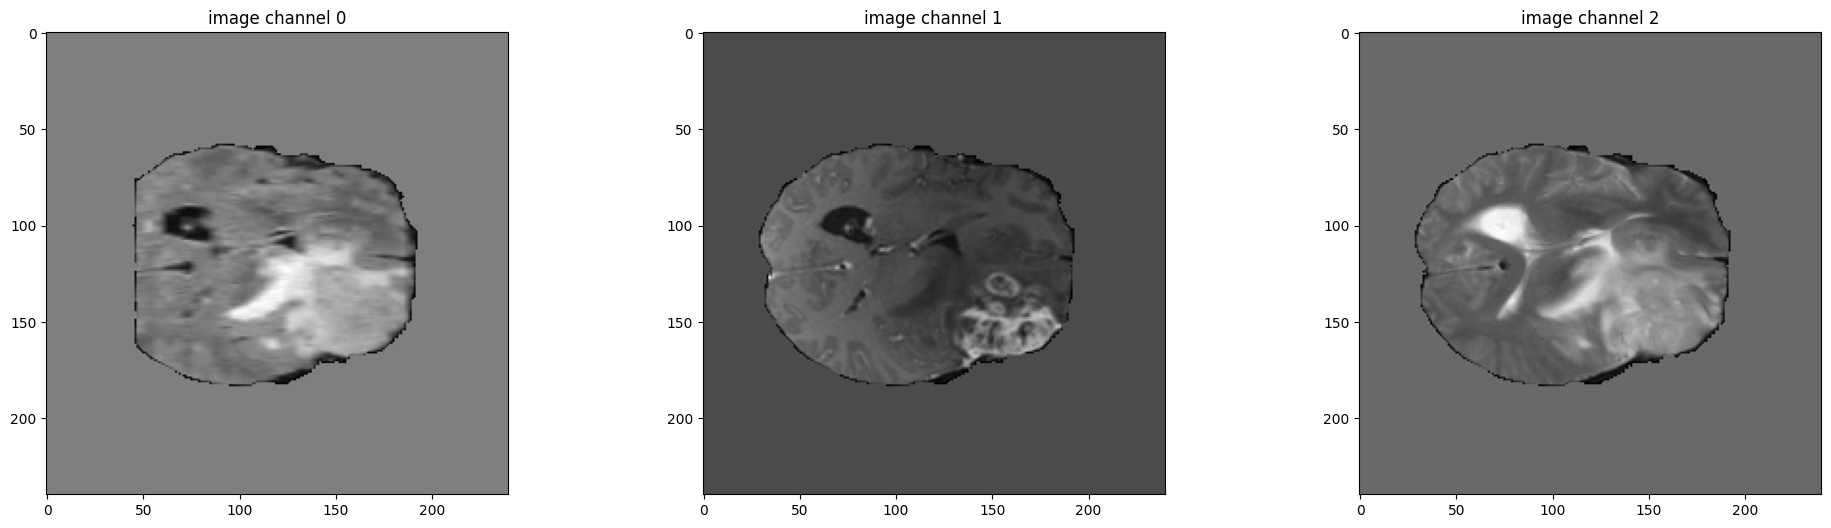

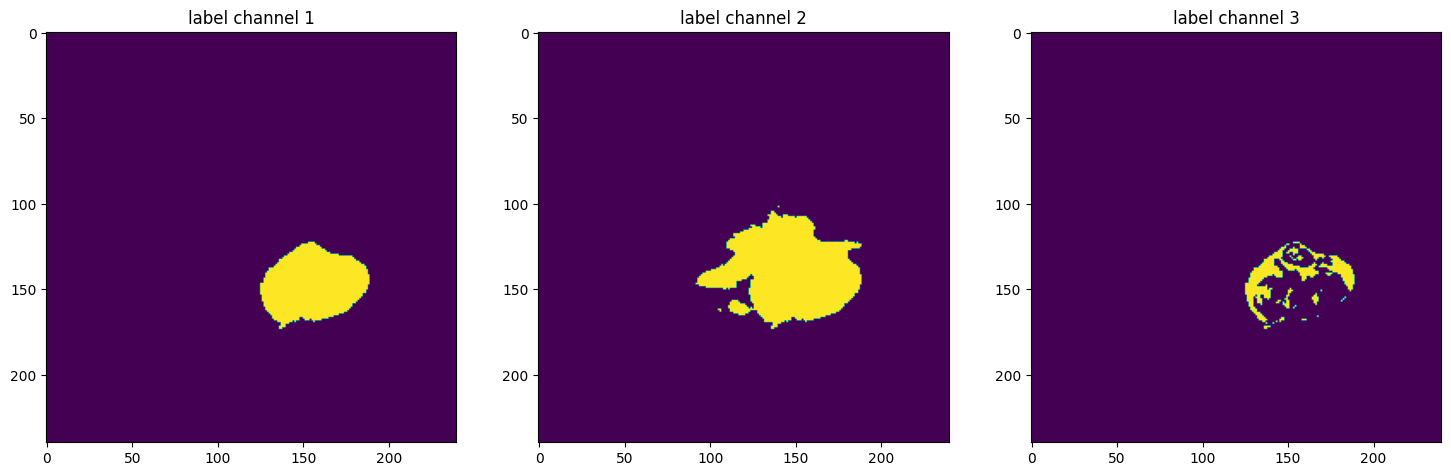

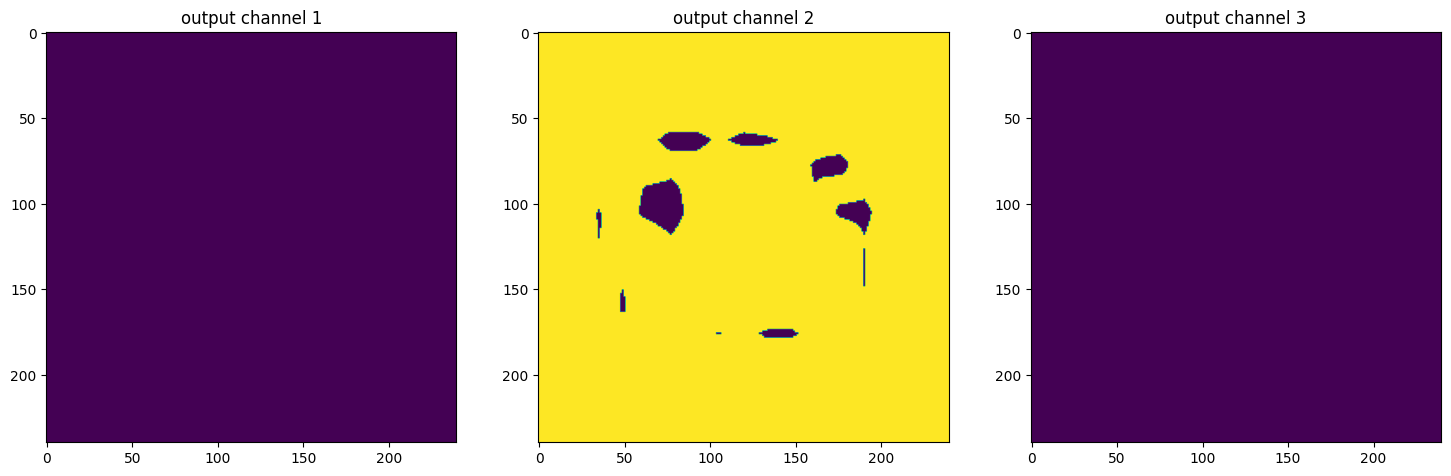

Training completed.


In [ ]:
dice_metric = DiceMetric(include_background=False, reduction="mean_batch", get_not_nans=False)

val_loader = DataLoader(val_ds, num_workers=1, pin_memory=torch.cuda.is_available())
val_batch = next(iter(val_loader))

val_images = val_batch["image"].to(device)
val_gt = val_batch["label"].to(device)
input_slice = val_images[0, 0].cpu().numpy()

roi_size = (240, 240)  # Dimensions of 
sw_batch_size = 8    # Sliding window batch size
spatial_dim = 2       # Dimensione along which to apply the sliding window

slice_inferer = SliceInferer(
    roi_size=roi_size,
    sw_batch_size=sw_batch_size,
    spatial_dim=spatial_dim,
    device=torch.device("cuda" if torch.cuda.is_available() else "cpu"),  # Adaptive device
    padding_mode="replicate",
)

loss_fct = monai.losses.DiceLoss(softmax=True, to_onehot_y=False)

epoch_loss_values = []
num_epochs = 10
best_loss = float("inf")
checkpoint_dir = "checkpoints"
checkpoint_path = os.path.join(checkpoint_dir, "interrupted_checkpoint.pth")

start_epoch = 0
if os.path.exists(checkpoint_path):
    print(f"Resuming from checkpoint: {checkpoint_path}")
    checkpoint = torch.load(checkpoint_path, map_location=device, weights_only=False)
    model.load_state_dict(checkpoint["model_state"])
    optimizer.load_state_dict(checkpoint["optimizer_state"])
    start_epoch = checkpoint["epoch"]
    epoch_loss_values = checkpoint["loss_values"]
    best_loss = checkpoint["best_loss"]
else:
    print("No checkpoint found. Starting training from scratch.")


try:
    for epoch in range(start_epoch, num_epochs):
        model.train()
        print("-" * 10)
        print(f"epoch {epoch + 1}/{num_epochs}")
        epoch_loss, step = 0, 0
        for batch_data in train_loader:
            step += 1
            inputs, labels = batch_data["image"].to(device), batch_data["label"].to(device)
            optimizer.zero_grad()
            outputs = model(pixel_values=inputs, labels=labels)

            loss = outputs.loss
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

            if step % 200 == 0:
                print(f"{step}, train_loss: {loss.item():.4f}")
        epoch_loss /= step
        epoch_loss_values.append(epoch_loss)
        print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

        model.eval()
        if epoch % 1 == 0: 
            with torch.no_grad():
                val_output = slice_inferer(val_images, model)
                val_output_tensor = val_output["logits"] if "logits" in val_output else val_output["out"]

                val_loss = loss_fct(val_output_tensor, val_gt)

                if val_loss < best_loss:
                    best_loss = val_loss
                    print(f"New best loss: {best_loss:.4f}")
                    torch.save(model.state_dict(), os.path.join(checkpoint_dir, f"best_model_epoch_{epoch+1}.pth"))
                    
                # Early stopping
                if epoch > 20 and all(abs(epoch_loss_values[-i] - epoch_loss_values[-i - 1]) < 1e-7 for i in range(1, 21)):
                    print("Early stopping: no improvement in 20 epochs.")
                    torch.save(model.state_dict(), os.path.join(checkpoint_dir, f"earlystop_model_epoch_{epoch+1}.pth"))
                    break

                # Save periodic checkpoint
                if (epoch + 1) % 20 == 0:
                    torch.save(model.state_dict(), os.path.join(checkpoint_dir, f"model_epoch_{epoch+1}.pth"))
                    print(f"Checkpoint saved for epoch {epoch+1}")

                val_probs = torch.softmax(val_output_tensor, dim=1)

                # Apply argmax along the channel dimension
                val_pred = torch.argmax(val_probs, dim=1)  # Shape: [B, H, W, D]
                
                # Convert predicted labels into one-hot encoded format
                val_pred_onehot = torch.nn.functional.one_hot(val_pred, num_classes=val_probs.shape[1])  # [B, H, W, D, C]
                
                # Permute to shape [B, C, H, W, D] to match the original channel-first format
                val_pred_onehot = val_pred_onehot.permute(0, 4, 1, 2, 3).float()

                dice_scores = dice_metric(y_pred=val_pred_onehot, y=val_gt) 
                print(f"Dice per channel: {dice_scores}")
                current_dice = dice_metric.aggregate().mean().item()
                print(f"Current dice: {current_dice}")

                plt.figure("image", (24, 6))
                
                for i in range(3):
                    plt.subplot(1, 3, i + 1)
                    plt.title(f"image channel {i}")
                    plt.imshow(val_images[0][i, :, :, 70].detach().cpu(), cmap="gray")
                plt.show()
                # visualize the 3 channels label corresponding to this image
                plt.figure("label", (18, 6))
                for i in range(1, 4):
                    plt.subplot(1, 3, i)
                    plt.title(f"label channel {i}")
                    plt.imshow(val_gt[0][i, :, :, 70].detach().cpu(),  vmin=0, vmax=1)
                plt.show()
                # visualize the 3 channels model output corresponding to this image
                plt.figure("output argmax", (18, 6))
                for i in range(1, 4):
                    plt.subplot(1, 3, i)
                    plt.title(f"output channel {i}")
                    plt.imshow(val_pred_onehot[0][i, :, :, 70].detach().cpu(), vmin=0, vmax=1)
                plt.show()       


except KeyboardInterrupt:
    print("Training interrupted! Saving latest checkpoint...")
    torch.save({
        "model_state": model.state_dict(),
        "optimizer_state": optimizer.state_dict(),
        "epoch": epoch + 1,
        "loss_values": epoch_loss_values,
        "best_loss": best_loss
    }, os.path.join(checkpoint_dir, "interrupted_checkpoint.pth"))
    print("Checkpoint saved. Exiting...")

print("Training completed.")

In [ ]:
model_path = "checkpoints/model_final.pth"
torch.save(model.state_dict(), model_path)
model.load_state_dict(torch.load("model_trained.pt"))

In [ ]:

data_loader = DataLoader(val_ds, num_workers=1, pin_memory=torch.cuda.is_available())
dice_metric = DiceMetric(include_background=True, reduction="mean_batch", get_not_nans=False)
model.eval()

sample_batch = next(iter(data_loader))
print(f"Dimensioni batch di esempio - immagini: {sample_batch['image'].shape}, labels: {sample_batch['label'].shape}")

roi_size = (240, 240)  
sw_batch_size = 8    
spatial_dim = 2     

slice_inferer = SliceInferer(
    roi_size=roi_size,
    sw_batch_size=sw_batch_size,
    spatial_dim=spatial_dim,
    device=torch.device("cuda" if torch.cuda.is_available() else "cpu"),  # Adaptive device
    padding_mode="replicate",
)

with torch.no_grad():
    for batch_idx, val_data in enumerate(data_loader):
        val_images = val_data["image"].to(device)
        val_gt = val_data["label"].to(device)
        
        val_output = slice_inferer(val_images, model)
        val_output_tensor = val_output["logits"] if "logits" in val_output else val_output["out"]
        val_probs = torch.softmax(val_output_tensor, dim=1)

        val_pred = torch.argmax(val_probs, dim=1)  # Shape: [B, H, W, D]
                
        # Convert predicted labels into one-hot encoded format
        val_pred_onehot = torch.nn.functional.one_hot(val_pred, num_classes=val_probs.shape[1])  # [B, H, W, D, C]
                
        # Permute to shape [B, C, H, W, D] to match the original channel-first format
        val_pred_onehot = val_pred_onehot.permute(0, 4, 1, 2, 3).float()
        
      
        dice_scores = dice_metric(y_pred=val_pred_onehot, y=val_gt)
        current_dice = dice_metric.aggregate().mean().item()  
        print(f"Batch {batch_idx} - Dice: {current_dice:.4f}")

        if batch_idx == 0:
            plt.figure("image", (24, 6))
            for i in range(3):
                plt.subplot(1, 3, i + 1)
                plt.title(f"image channel {i}")
                plt.imshow(val_images[0][i, :, :, 70].detach().cpu(), cmap="gray")
            plt.show()
            # visualize the 3 channels label corresponding to this image
            plt.figure("label", (18, 6))
            for i in range(1, 4):
                plt.subplot(1, 3, i)
                plt.title(f"label channel {i}")
                plt.imshow(val_gt[0][i, :, :, 70].detach().cpu(),  vmin=0, vmax=1)
            plt.show()
            # visualize the 3 channels model output corresponding to this image
            plt.figure("output argmax", (18, 6))
            for i in range(1, 4):
                plt.subplot(1, 3, i)
                plt.title(f"output channel {i}")
                plt.imshow(val_pred_onehot[0][i, :, :, 70].detach().cpu(), vmin=0, vmax=1)
            plt.show()   
            
    dice_scores = dice_metric.aggregate()
    avg_dice = dice_scores.mean().item()
    std_dice = dice_scores.std().item() if len(dice_scores) > 1 else 0.0
    print(f"\nFinal result - Dice: {avg_dice:.4f} ± {std_dice:.4f}")
    